# Project Description

## Motivation


<i><b>For Jan</b>: Insert business value</i>

## Data Source

<i><b>For Jan</b>: Insert write up</i>

Note: https://www.sciencedirect.com/science/article/abs/pii/S0379073824001944

## Main Problem

<i><b>For Jan</b>: Insert main problem</i>

Sample: What models can be recommended that provides the highest accuracy depending on the resolution level?

## Limitations

In the study "YHP: Y-chromosome Haplogroup Predictor for predicting male lineages based on Y-STRs", the researchers classified the different haplogroups into 18 resolutions, wherein each resolution was used to train and test the different machine learning models. Grouping the haplogroups into resolutions requires further research to ensure correctness of classification. 

With this in mind, this study no longer classified the haplogroups into resolution. Instead, the entire data set was utilized in training and testing machine learning models.

# Methodology

Step 1. Identify the Business Problem

Step 2. Identify the Machine Learning Task

Step 3. Identify Key Evaluation Metrics

Step 4. Build and Test Machine Learning Models

## 1. Identify the Business Problem

<i><b>For Jan</b>: Rephrase motivation and main problem</i>

## 2. Identify the Machine Learning Task

What will the machine learning model do?
- Goal is to predict the class label (i.e. haplogroup) choice from a predefined list of states (i.e. 27 Y-STRs)

Classification Problem
- Input: Y-STRs (e.g Column DYS576, Column DYS627)
- Output: Haplogroups (i.e. Column haplogroup)

Since this is a classification problem, the following models will be utilized.
1. KNN
2. LDA
3. Gaussian Naive Bayes
4. Decision Tree
5. Random Forest
6. Gradient Boosting

For KNN, scaling will be applied during the data preprocessing to help with faster convergence, equal feature contribution, and improved performance [2][3].

Note that Logistic Regression (L1, L2) will not be used because of the assumption of linearity between the dependent variable and the independent variables [4]. Given that the dataset has overlapping classes as seen in 4.2 EDA, it will be difficult to establish the linearity between the target and the features.

SVM will also not be used because the dataset has overlapping classes [5]. As an example, plotting two of the features (i.e. DYS627 and DYS576) show overlaps between the four haplogroups (i.e. R1a1a1b2a2, O2a2b1a1a1, O2a2a1, O2a2b1a2a1) as seen in 4.2 EDA

## 3. Identify Key Evaluation Metrics

<i><b>For Jan</b>: What evaluation metric will we use? If we will use Accuracy, explain why we will use Accuracy as the evalutation metric.

We also need to look for any industry benchmarks on Accuracy. Otherwise, we can proceed to using PCC.</i>

Evaluation Metrics: Classification
- Accuracy: use when the goal is to minimize the overall error state
- Precision: use when the cost of false positives is high
- Recall: use when the cost of false negatives is high
- F1-score: use if you want to optimize precision and recall at the same time

### PCC for Benchmark

## 4. Build and Test Machine Learning Models

In [5]:
import numpy as np
import pandas as pd
import math
import time
import re
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, ShuffleSplit, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, f1_score, accuracy_score, ConfusionMatrixDisplay, confusion_matrix, matthews_corrcoef, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from collections import Counter
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### Gradient Boosting

In [37]:
# Step 1. Load dataset
df = pd.read_excel('Supplemental Processed Data Set.xlsx', sheet_name='S Table 1', skiprows=1)
# Step 2. Fill NaN values
df = df.ffill()
# Step 3. Split haplotype into separate columns
df = pd.concat([df, df['haplotype'].str.replace('[', '').str.replace(']', '').str.split(',', expand=True)], axis=1)
YSTRs = {0: "DYS576", 1: "DYS389 I", 2: "DYS635", 3: "DYS389 II", 4: "DYS627", 5: "DYS460", 6: "DYS458",
                 7: "DYS19", 8: "Y-GATA-H4", 9: "DYS448", 10: "DYS391", 11: "DYS456", 12: "DYS390", 13: "DYS438", 
                 14: "DYS392", 15: "DYS518", 16: "DYS570", 17: "DYS437", 18: "DYS385a", 19: "DYS385b", 20: "DYS449", 
                 21: "DYS393", 22: "DYS439", 23: "DYS481", 24: "DYS576a", 25: "DYS576b", 26: "DYS533"
}

df = df.rename(columns=YSTRs)
df = df.drop(columns=['haplotype'])
df

,haplogroup,number of haplotypes,total frequency,sampleID,population,frequency,DYS576,DYS389 I,DYS635,DYS389 II,...,DYS437,DYS385a,DYS385b,DYS449,DYS393,DYS439,DYS481,DYS576a,DYS576b,DYS533
0,C2b1a1a,4.0,1.0,HLM100,Hulunbuir[Mongolian],1.0,19.0,14.0,22.0,31.0,...,14.0,11.0,19.0,30.0,14.0,12.0,24.0,36.0,39.0,12.0
1,C2b1a1a,4.0,1.0,HHM158,Hohhot[Mongolian],1.0,19.0,14.0,22.0,30.0,...,14.0,11.0,17.0,30.0,14.0,14.0,24.0,39.0,39.0,12.0
2,C2b1a1a,4.0,1.0,ODM030,Ordos[Mongolian],1.0,18.0,14.0,21.0,31.0,...,14.0,11.0,19.0,30.0,14.0,12.0,23.0,37.0,38.0,12.0
3,C2b1a1a,4.0,1.0,HLM178,Hulunbuir[Mongolian],1.0,19.0,14.0,22.0,30.0,...,14.0,11.0,17.0,30.0,14.0,14.0,24.0,39.0,39.0,12.0
4,O2a2b1a1a1a4a1,6.0,1.0,HHM088,Hohhot[Mongolian],1.0,18.0,12.0,20.0,29.0,...,16.0,14.0,18.0,32.0,11.0,13.0,23.0,35.0,37.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4059,O2a1c1a1a1,14.0,1.0,HaiN153(Han),Han,1.0,20.0,12.0,20.0,28.0,...,14.0,13.0,13.0,31.0,13.0,11.0,25.0,37.0,40.0,11.0
4060,O2a1c1a1a1,14.0,1.0,GD-16(Han),Han,1.0,18.0,12.0,21.0,28.0,...,14.0,12.0,19.0,31.0,12.0,12.0,28.0,36.0,38.0,11.0
4061,O2a1c1a1a1,14.0,1.0,JX-82(Han),Han,1.0,19.0,12.0,21.0,28.0,...,14.0,12.0,19.0,33.0,12.0,12.0,26.0,36.0,39.0,11.0
4062,O2a1c1a1a1,14.0,1.0,HaiN139(Han),Han,1.0,16.0,14.0,21.0,29.0,...,14.0,12.0,18.0,29.0,14.0,12.0,23.0,37.0,39.0,11.0


In [38]:
# ======================================================
# 3. MUTATION-AWARE FEATURE ENGINEERING (Final Extended + Normalized + Regional Rates)
# ======================================================

# ------------------------------------------------------
# Define Yfiler Plus mutation-rate groups (canonical names)
# ------------------------------------------------------
fast_loci = ["DYS570", "DYS576", "DYS458", "DYS449", "DYS627", "DYS481"]
intermediate_loci = [
    "DYS385a", "DYS385b", "DYS533", "DYS19", "DYS391",
    "DYS518", "DYS635", "DYS390", "DYS392", "DYS393"
]
slow_loci = [
    "DYS438", "DYS437", "DYS439", "DYS389I", "DYS389II",
    "DYS460", "DYS456", "Y_GATA_H4", "DYS448"
]

# ------------------------------------------------------
# Identify available STR columns
# ------------------------------------------------------
available_str_cols = [c for c in df.columns if any(k in c for k in ["DYS", "Y_GATA", "YGATA"])]
print(f"Detected {len(available_str_cols)} STR columns:", available_str_cols)

# ------------------------------------------------------
# Adjust loci lists to only include those present
# ------------------------------------------------------
fast_loci = [l for l in fast_loci if l in df.columns]
intermediate_loci = [l for l in intermediate_loci if l in df.columns]
slow_loci = [l for l in slow_loci if l in df.columns]
str_cols = list(set(fast_loci + intermediate_loci + slow_loci))

print(f"\nUsing {len(str_cols)} STR loci after filtering:")
print(str_cols)

# ------------------------------------------------------
# Ensure numeric STR data
# ------------------------------------------------------
df[str_cols] = df[str_cols].apply(pd.to_numeric, errors="coerce")

# ------------------------------------------------------
# Remove haplogroups with only one sample
# ------------------------------------------------------
hap_col = df.columns[0]
counts = df[hap_col].value_counts()
df = df[df[hap_col].isin(counts[counts > 1].index)].copy()

# ------------------------------------------------------
# Compute haplogroup centroids
# ------------------------------------------------------
centroids = df.groupby(hap_col)[str_cols].mean()

# ------------------------------------------------------
# Choose mutation-rate weighting scheme
# ------------------------------------------------------
mutation_weight_context = "east_asian"  # options: "global" (Ballantyne) or "east_asian"

if mutation_weight_context == "global":
    # Ballantyne-style global relative mutation speeds
    weight_fast, weight_intermediate, weight_slow = 3.0, 2.0, 1.0
else:
    # Adjusted for East Asian populations (Wang et al. 2016, Zhang et al. 2025, Moon et al. 2022)
    weight_fast, weight_intermediate, weight_slow = 2.0, 1.5, 1.0

weights = {l: weight_fast for l in fast_loci}
weights.update({l: weight_intermediate for l in intermediate_loci})
weights.update({l: weight_slow for l in slow_loci})

# ------------------------------------------------------
# L1 distance to haplogroup centroid
# ------------------------------------------------------
def l1_to_centroid(row):
    hg = row[hap_col]
    if hg not in centroids.index:
        return np.nan
    centroid = centroids.loc[hg]
    return np.abs(row[str_cols] - centroid).sum()

df["l1_centroid"] = df.apply(l1_to_centroid, axis=1)

# ------------------------------------------------------
# Weighted L1 (based on regional weighting)
# ------------------------------------------------------
df["weighted_l1_centroid"] = df.apply(
    lambda r: sum(
        abs(r[c] - centroids.loc[r[hap_col], c]) * weights.get(c, weight_intermediate)
        for c in str_cols if c in centroids.columns
    ),
    axis=1
)

# ------------------------------------------------------
# Global allele statistics
# ------------------------------------------------------
df["allele_sum"] = df[str_cols].sum(axis=1)
df["allele_var"] = df[str_cols].var(axis=1)
df["allele_mean"] = df[str_cols].mean(axis=1)
df["allele_std"] = df[str_cols].std(axis=1)

# ------------------------------------------------------
# Median-based and skewness proxies
# ------------------------------------------------------
df["allele_median"] = df[str_cols].median(axis=1)
df["median_deviation"] = df["allele_median"] - df["allele_mean"]
df["skewness_proxy"] = (df["allele_mean"] - df["allele_median"]) / (df["allele_std"] + 1e-9)

# ------------------------------------------------------
# Mutation-category-specific variation
# ------------------------------------------------------
df["fast_var"] = df[fast_loci].var(axis=1) if fast_loci else np.nan
df["slow_stability"] = (
    -df[slow_loci].sub(df[slow_loci].mean(), axis=1).abs().sum(axis=1)
    if slow_loci else np.nan
)

# ------------------------------------------------------
# Fast-to-slow ratio and heterogeneity index
# ------------------------------------------------------
if fast_loci and slow_loci:
    df["fast_slow_ratio"] = df[fast_loci].mean(axis=1) / (df[slow_loci].mean(axis=1) + 1e-9)
else:
    df["fast_slow_ratio"] = np.nan

df["heterogeneity_index"] = df["allele_std"] / (df["allele_mean"] + 1e-9)

# ------------------------------------------------------
# Pairwise differential features
# ------------------------------------------------------
pair_loci = [("DYS385a", "DYS385b"), ("DYS389I", "DYS389II")]
for a, b in pair_loci:
    if a in df.columns and b in df.columns:
        df[f"{a}_{b}_diff"] = (df[a] - df[b]).abs()

# ------------------------------------------------------
# Mutation-weighted summary statistics
# ------------------------------------------------------
def weighted_summary(row):
    vals = [row[locus] * weights.get(locus, weight_intermediate) for locus in str_cols]
    return np.mean(vals), np.var(vals)

df["weighted_mean"], df["weighted_var"] = zip(*df.apply(weighted_summary, axis=1))

# ------------------------------------------------------
# Normalize engineered numeric features
# ------------------------------------------------------
scaler = StandardScaler()
to_scale = [
    "l1_centroid", "weighted_l1_centroid", "allele_sum", "allele_mean", "allele_std",
    "allele_var", "fast_var", "slow_stability", "fast_slow_ratio", "heterogeneity_index",
    "weighted_mean", "weighted_var", "median_deviation", "skewness_proxy"
]
df[to_scale] = scaler.fit_transform(df[to_scale])

# ------------------------------------------------------
# Summary of added features
# ------------------------------------------------------
added_features = to_scale + [
    f"{a}_{b}_diff" for a, b in pair_loci if a in df.columns and b in df.columns
]

print(f"\nMutation-aware and regionally weighted features added ({mutation_weight_context} model):")
print(added_features)

Detected 26 STR columns: ['DYS576', 'DYS389 I', 'DYS635', 'DYS389 II', 'DYS627', 'DYS460', 'DYS458', 'DYS19', 'DYS448', 'DYS391', 'DYS456', 'DYS390', 'DYS438', 'DYS392', 'DYS518', 'DYS570', 'DYS437', 'DYS385a', 'DYS385b', 'DYS449', 'DYS393', 'DYS439', 'DYS481', 'DYS576a', 'DYS576b', 'DYS533']

Using 22 STR loci after filtering:
['DYS385b', 'DYS438', 'DYS458', 'DYS392', 'DYS570', 'DYS627', 'DYS576', 'DYS448', 'DYS393', 'DYS533', 'DYS456', 'DYS390', 'DYS437', 'DYS391', 'DYS635', 'DYS460', 'DYS385a', 'DYS518', 'DYS481', 'DYS449', 'DYS439', 'DYS19']

Mutation-aware and regionally weighted features added (east_asian model):
['l1_centroid', 'weighted_l1_centroid', 'allele_sum', 'allele_mean', 'allele_std', 'allele_var', 'fast_var', 'slow_stability', 'fast_slow_ratio', 'heterogeneity_index', 'weighted_mean', 'weighted_var', 'median_deviation', 'skewness_proxy', 'DYS385a_DYS385b_diff']


# RandomForest and LightGBM

In [6]:
# ======================================================
# 1. PREPARE DATA
# ======================================================
hap_col = df.columns[0]
df["major_clade"] = df[hap_col].str.extract(r"^([A-Z])")

X = df.iloc[:, 6:].apply(pd.to_numeric, errors="coerce")
y_major = df["major_clade"]
y_full = df[hap_col]

# ======================================================
# 2. SPLIT DATA (Singleton-safe)
# ======================================================
mask = y_major.value_counts()[y_major].values > 1
X_filtered, y_filtered = X[mask], y_major[mask]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_idx, test_idx in sss.split(X_filtered, y_filtered):
    X_train, X_test = X_filtered.iloc[train_idx], X_filtered.iloc[test_idx]
    y_train, y_test = y_filtered.iloc[train_idx], y_filtered.iloc[test_idx]

X_train = pd.concat([X_train, X[~mask]])
y_train = pd.concat([y_train, y_major[~mask]])

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

# ======================================================
# 3. DEFINE MODEL BUILDERS
# ======================================================
def make_rf():
    return RandomForestClassifier(
        n_estimators=300,
        max_depth=8,
        min_samples_leaf=5,
        min_samples_split=10,
        max_features="sqrt",
        class_weight="balanced",
        n_jobs=-1,
        random_state=42,
    )


def make_lgbm():
    return LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=20,
        max_depth=7,
        min_data_in_leaf=20,
        feature_fraction=0.8,
        bagging_fraction=0.8,
        bagging_freq=5,
        reg_lambda=2.0,
        reg_alpha=1.0,
        is_unbalance=True,
        n_jobs=-1,
        random_state=42,
        verbose=-1,
    )


# ======================================================
# 4. K-FOLD CV FUNCTION
# ======================================================
def crossval_model(model_builder, X, y, k=5):
    """Performs Stratified K-Fold CV and returns mean train/test macro-F1 and accuracy."""
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    f1_train_scores, f1_test_scores = [], []
    acc_train_scores, acc_test_scores = [], []

    for train_idx, test_idx in skf.split(X, y):
        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

        model = model_builder()
        model.fit(X_tr, y_tr)

        y_pred_train = model.predict(X_tr)
        y_pred_test = model.predict(X_te)

        f1_train = f1_score(y_tr, y_pred_train, average="macro", zero_division=0)
        f1_test = f1_score(y_te, y_pred_test, average="macro", zero_division=0)
        acc_train = accuracy_score(y_tr, y_pred_train)
        acc_test = accuracy_score(y_te, y_pred_test)

        f1_train_scores.append(f1_train)
        f1_test_scores.append(f1_test)
        acc_train_scores.append(acc_train)
        acc_test_scores.append(acc_test)

    return (
        np.mean(f1_train_scores),
        np.mean(f1_test_scores),
        np.mean(acc_train_scores),
        np.mean(acc_test_scores),
    )


# ======================================================
# 5. MAJOR CLADE COMPARISON (K-FOLD)
# ======================================================
rf_f1_train, rf_f1_test, rf_acc_train, rf_acc_test = crossval_model(
    make_rf, X_train, y_train
)
lgbm_f1_train, lgbm_f1_test, lgbm_acc_train, lgbm_acc_test = crossval_model(
    make_lgbm, X_train, y_train
)

print("\nMAJOR CLADE (K-Fold Average Metrics)")
print(f"Random Forest - F1_macro_train: {rf_f1_train:.3f}, F1_macro_test: {rf_f1_test:.3f}, Acc_train: {rf_acc_train:.3f}, Acc_test: {rf_acc_test:.3f}")
print(f"LightGBM      - F1_macro_train: {lgbm_f1_train:.3f}, F1_macro_test: {lgbm_f1_test:.3f}, Acc_train: {lgbm_acc_train:.3f}, Acc_test: {lgbm_acc_test:.3f}")

# ======================================================
# 6. SUBCLADE COMPARISON (PER MAJOR CLADE, K-FOLD)
# ======================================================
sub_results = []

for clade in df["major_clade"].unique():
    sub_df = df[df["major_clade"] == clade]
    sub_X = sub_df.iloc[:, 6:].apply(pd.to_numeric, errors="coerce")
    sub_y = sub_df[hap_col]

    if sub_y.nunique() < 3 or len(sub_y) < 20:
        print(f"Skipping {clade}: only {len(sub_y)} samples, {sub_y.nunique()} subclades.")
        continue

    rf_f1_train, rf_f1_test, rf_acc_train, rf_acc_test = crossval_model(
        make_rf, sub_X, sub_y
    )
    lgbm_f1_train, lgbm_f1_test, lgbm_acc_train, lgbm_acc_test = crossval_model(
        make_lgbm, sub_X, sub_y
    )

    sub_results.append(
        {
            "Clade": clade,
            "RF_F1_Train": rf_f1_train,
            "RF_F1_Test": rf_f1_test,
            "RF_Acc_Train": rf_acc_train,
            "RF_Acc_Test": rf_acc_test,
            "LGBM_F1_Train": lgbm_f1_train,
            "LGBM_F1_Test": lgbm_f1_test,
            "LGBM_Acc_Train": lgbm_acc_train,
            "LGBM_Acc_Test": lgbm_acc_test,
            "RF_Overfit": rf_f1_train - rf_f1_test,
            "LGBM_Overfit": lgbm_f1_train - lgbm_f1_test,
            "n_classes": sub_y.nunique(),
            "n_samples": len(sub_y),
        }
    )

    print(
        f"Subclade {clade} - "
        f"RF F1_macro_test: {rf_f1_test:.3f}, Acc_test: {rf_acc_test:.3f} | "
        f"LGBM F1_macro_test: {lgbm_f1_test:.3f}, Acc_test: {lgbm_acc_test:.3f}"
    )

# ======================================================
# 7. SUMMARIZE RESULTS
# ======================================================
sub_results_df = pd.DataFrame(sub_results)
print("\nHierarchical K-Fold Model Comparison Summary:\n")
display(sub_results_df.sort_values("LGBM_F1_Test", ascending=False))

print("\nK-Fold hierarchical comparison complete.")

Train size: 3027, Test size: 1010

MAJOR CLADE (K-Fold Average Metrics)
Random Forest - F1_macro_train: 0.984, F1_macro_test: 0.854, Acc_train: 0.982, Acc_test: 0.968
LightGBM      - F1_macro_train: 0.989, F1_macro_test: 0.868, Acc_train: 1.000, Acc_test: 0.976
Subclade C - RF F1_macro_test: 0.553, Acc_test: 0.714 | LGBM F1_macro_test: 0.544, Acc_test: 0.732
Subclade O - RF F1_macro_test: 0.465, Acc_test: 0.515 | LGBM F1_macro_test: 0.500, Acc_test: 0.614
Subclade D - RF F1_macro_test: 0.589, Acc_test: 0.759 | LGBM F1_macro_test: 0.513, Acc_test: 0.748
Subclade Q - RF F1_macro_test: 0.541, Acc_test: 0.680 | LGBM F1_macro_test: 0.410, Acc_test: 0.571
Subclade R - RF F1_macro_test: 0.558, Acc_test: 0.682 | LGBM F1_macro_test: 0.504, Acc_test: 0.741
Subclade N - RF F1_macro_test: 0.604, Acc_test: 0.766 | LGBM F1_macro_test: 0.568, Acc_test: 0.788
Subclade J - RF F1_macro_test: 0.735, Acc_test: 0.817 | LGBM F1_macro_test: 0.692, Acc_test: 0.789
Skipping G: only 18 samples, 5 subclades.
Ski

,Clade,RF_F1_Train,RF_F1_Test,RF_Acc_Train,RF_Acc_Test,LGBM_F1_Train,LGBM_F1_Test,LGBM_Acc_Train,LGBM_Acc_Test,RF_Overfit,LGBM_Overfit,n_classes,n_samples
6,J,0.942445,0.735404,0.944722,0.817143,0.983400,0.692363,0.983161,0.788571,0.207041,0.291037,6,104
5,N,0.937534,0.603586,0.938656,0.765898,0.934554,0.567626,0.995349,0.788120,0.333949,0.366928,13,269
0,C,0.880509,0.552903,0.902294,0.713761,0.966538,0.544398,0.991743,0.732110,0.327606,0.422140,29,545
2,D,0.924070,0.588958,0.914815,0.759259,0.869369,0.512552,0.979630,0.748148,0.335112,0.356817,21,270
4,R,0.877770,0.558018,0.858589,0.682492,0.926041,0.504453,0.980839,0.740808,0.319752,0.421587,14,274
1,O,0.745151,0.464654,0.731061,0.515275,0.981838,0.499649,0.997174,0.614065,0.280497,0.482188,90,2389
3,Q,0.951899,0.540689,0.928539,0.679532,0.829231,0.410357,0.925761,0.570760,0.411210,0.418874,7,91



K-Fold hierarchical comparison complete.


In [9]:
# ======================================================
# 1. PREPARE DATA
# ======================================================
hap_col = df.columns[0]
df["major_clade"] = df[hap_col].str.extract(r"^([A-Z])")

X = df.iloc[:, 6:].apply(pd.to_numeric, errors="coerce")
y_major = df["major_clade"]
y_full = df[hap_col]

# ======================================================
# 2. SPLIT DATA (Singleton-safe)
# ======================================================
mask = y_major.value_counts()[y_major].values > 1
X_filtered, y_filtered = X[mask], y_major[mask]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_idx, test_idx in sss.split(X_filtered, y_filtered):
    X_train, X_test = X_filtered.iloc[train_idx], X_filtered.iloc[test_idx]
    y_train, y_test = y_filtered.iloc[train_idx], y_filtered.iloc[test_idx]

X_train = pd.concat([X_train, X[~mask]])
y_train = pd.concat([y_train, y_major[~mask]])

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

# ======================================================
# 3. DEFINE MODEL BUILDERS
# ======================================================
def make_rf():
    return RandomForestClassifier(
        n_estimators=300,
        max_depth=8,
        min_samples_leaf=5,
        min_samples_split=10,
        max_features="sqrt",
        class_weight=None,
        n_jobs=-1,
        random_state=42,
    )

def make_lgbm():
    return LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=20,
        max_depth=7,
        min_data_in_leaf=20,
        feature_fraction=0.8,
        bagging_fraction=0.8,
        bagging_freq=5,
        reg_lambda=2.0,
        reg_alpha=1.0,
        is_unbalance=False,
        n_jobs=-1,
        random_state=42,
        verbose=-1,
    )

# ======================================================
# 4. SMOTE-ENABLED CV FUNCTION WITH STRONG IMPUTATION
# ======================================================
def impute_strong(X, global_medians=None):
    """Fill NaNs using per-column median; if still NaN, fallback to global medians."""
    X_imputed = X.copy()
    medians = X_imputed.median()
    X_imputed = X_imputed.fillna(medians)
    # If still NaN (entire column missing in this fold), fill from global medians
    if global_medians is not None:
        X_imputed = X_imputed.fillna(global_medians)
    # Final safety: fill anything left with 0 (very rare)
    X_imputed = X_imputed.fillna(0)
    return X_imputed


def smote_fit_resample_safe(X_tr, y_tr, global_medians, random_state=42):
    """SMOTE only on classes with >=2 samples. Duplicate singletons instead."""
    y_tr = y_tr.copy()
    X_tr = impute_strong(X_tr, global_medians)

    counts = y_tr.value_counts()
    singletons = counts[counts == 1].index
    mask_single = y_tr.isin(singletons)

    X_single = X_tr[mask_single]
    y_single = y_tr[mask_single]
    X_multi  = X_tr[~mask_single]
    y_multi  = y_tr[~mask_single]

    if len(y_multi.unique()) <= 1 or len(y_multi) == 0:
        X_bal = pd.concat([X_tr, X_single], axis=0)
        y_bal = pd.concat([y_tr, y_single], axis=0)
        return X_bal, y_bal

    min_count_multi = y_multi.value_counts().min()
    k = max(1, min(5, min_count_multi - 1))

    sm = SMOTE(k_neighbors=k, random_state=random_state)
    X_res, y_res = sm.fit_resample(X_multi, y_multi)

    X_res = pd.concat([X_res, X_single, X_single], axis=0)
    y_res = pd.concat([y_res, y_single, y_single], axis=0)
    return X_res, y_res


def crossval_model(model_builder, X, y, k=5):
    """Stratified K-Fold CV with safe SMOTE and robust NaN imputation."""
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    f1_train_scores, f1_test_scores = [], []
    acc_train_scores, acc_test_scores = [], []

    # Compute global medians once from entire dataset (for safety fallback)
    global_medians = X.median()

    for train_idx, test_idx in skf.split(X, y):
        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

        X_tr = impute_strong(X_tr, global_medians)
        X_te = impute_strong(X_te, global_medians)

        X_tr_res, y_tr_res = smote_fit_resample_safe(X_tr, y_tr, global_medians, random_state=42)

        model = model_builder()
        model.fit(X_tr_res, y_tr_res)

        y_pred_train = model.predict(X_tr_res)
        y_pred_test = model.predict(X_te)

        f1_train = f1_score(y_tr_res, y_pred_train, average="macro", zero_division=0)
        f1_test = f1_score(y_te, y_pred_test, average="macro", zero_division=0)
        acc_train = accuracy_score(y_tr_res, y_pred_train)
        acc_test = accuracy_score(y_te, y_pred_test)

        f1_train_scores.append(f1_train)
        f1_test_scores.append(f1_test)
        acc_train_scores.append(acc_train)
        acc_test_scores.append(acc_test)

    return (
        np.mean(f1_train_scores),
        np.mean(f1_test_scores),
        np.mean(acc_train_scores),
        np.mean(acc_test_scores),
    )

# ======================================================
# 5. MAJOR CLADE COMPARISON (K-FOLD + SMOTE + IMPUTATION)
# ======================================================
rf_f1_train, rf_f1_test, rf_acc_train, rf_acc_test = crossval_model(make_rf, X_train, y_train)
lgbm_f1_train, lgbm_f1_test, lgbm_acc_train, lgbm_acc_test = crossval_model(make_lgbm, X_train, y_train)

print("\nMAJOR CLADE (K-Fold + SMOTE + Strong Imputation)")
print(f"Random Forest - F1_macro_train: {rf_f1_train:.3f}, F1_macro_test: {rf_f1_test:.3f}, Acc_train: {rf_acc_train:.3f}, Acc_test: {rf_acc_test:.3f}")
print(f"LightGBM      - F1_macro_train: {lgbm_f1_train:.3f}, F1_macro_test: {lgbm_f1_test:.3f}, Acc_train: {lgbm_acc_train:.3f}, Acc_test: {lgbm_acc_test:.3f}")

# ======================================================
# 6. SUBCLADE COMPARISON (PER MAJOR CLADE, K-FOLD + SMOTE)
# ======================================================
sub_results = []

for clade in df["major_clade"].unique():
    sub_df = df[df["major_clade"] == clade]
    sub_X = sub_df.iloc[:, 6:].apply(pd.to_numeric, errors="coerce")
    sub_y = sub_df[hap_col]

    if sub_y.nunique() < 3 or len(sub_y) < 20:
        print(f"Skipping {clade}: only {len(sub_y)} samples, {sub_y.nunique()} subclades.")
        continue

    rf_f1_train, rf_f1_test, rf_acc_train, rf_acc_test = crossval_model(make_rf, sub_X, sub_y)
    lgbm_f1_train, lgbm_f1_test, lgbm_acc_train, lgbm_acc_test = crossval_model(make_lgbm, sub_X, sub_y)

    sub_results.append({
        "Clade": clade,
        "RF_F1_Train": rf_f1_train,
        "RF_F1_Test": rf_f1_test,
        "RF_Acc_Train": rf_acc_train,
        "RF_Acc_Test": rf_acc_test,
        "LGBM_F1_Train": lgbm_f1_train,
        "LGBM_F1_Test": lgbm_f1_test,
        "LGBM_Acc_Train": lgbm_acc_train,
        "LGBM_Acc_Test": lgbm_acc_test,
        "RF_Overfit": rf_f1_train - rf_f1_test,
        "LGBM_Overfit": lgbm_f1_train - lgbm_f1_test,
        "n_classes": sub_y.nunique(),
        "n_samples": len(sub_y),
    })

    print(
        f"Subclade {clade} - "
        f"RF F1_macro_test: {rf_f1_test:.3f}, Acc_test: {rf_acc_test:.3f} | "
        f"LGBM F1_macro_test: {lgbm_f1_test:.3f}, Acc_test: {lgbm_acc_test:.3f}"
    )

# ======================================================
# 7. SUMMARIZE RESULTS
# ======================================================
sub_results_df = pd.DataFrame(sub_results)
print("\nHierarchical K-Fold Model Comparison Summary (with SMOTE + Robust Imputation):\n")
display(sub_results_df.sort_values("LGBM_F1_Test", ascending=False))

print("\nK-Fold hierarchical comparison complete.")

Train size: 3027, Test size: 1010


  File "c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^



MAJOR CLADE (K-Fold + SMOTE + Strong Imputation)
Random Forest - F1_macro_train: 0.994, F1_macro_test: 0.882, Acc_train: 0.994, Acc_test: 0.972
LightGBM      - F1_macro_train: 1.000, F1_macro_test: 0.876, Acc_train: 1.000, Acc_test: 0.978
Subclade C - RF F1_macro_test: 0.556, Acc_test: 0.723 | LGBM F1_macro_test: 0.568, Acc_test: 0.739
Subclade O - RF F1_macro_test: 0.457, Acc_test: 0.526 | LGBM F1_macro_test: 0.513, Acc_test: 0.617
Subclade D - RF F1_macro_test: 0.556, Acc_test: 0.770 | LGBM F1_macro_test: 0.507, Acc_test: 0.744
Subclade Q - RF F1_macro_test: 0.452, Acc_test: 0.626 | LGBM F1_macro_test: 0.606, Acc_test: 0.713
Subclade R - RF F1_macro_test: 0.552, Acc_test: 0.708 | LGBM F1_macro_test: 0.585, Acc_test: 0.763
Subclade N - RF F1_macro_test: 0.597, Acc_test: 0.788 | LGBM F1_macro_test: 0.591, Acc_test: 0.784
Subclade J - RF F1_macro_test: 0.713, Acc_test: 0.798 | LGBM F1_macro_test: 0.733, Acc_test: 0.798
Skipping G: only 18 samples, 5 subclades.
Skipping I: only 12 sampl

,Clade,RF_F1_Train,RF_F1_Test,RF_Acc_Train,RF_Acc_Test,LGBM_F1_Train,LGBM_F1_Test,LGBM_Acc_Train,LGBM_Acc_Test,RF_Overfit,LGBM_Overfit,n_classes,n_samples
6,J,0.970441,0.713193,0.970690,0.798095,1.000000,0.733206,1.000000,0.797619,0.257248,0.266794,6,104
3,Q,0.851397,0.451556,0.955333,0.625731,0.997618,0.606228,0.997260,0.712865,0.399841,0.391390,7,91
5,N,0.938174,0.597363,0.982413,0.788330,1.000000,0.591127,1.000000,0.784486,0.340812,0.408873,13,269
4,R,0.953218,0.551988,0.981095,0.708081,0.998678,0.585169,0.998637,0.762828,0.401229,0.413510,14,274
0,C,0.952361,0.555930,0.965652,0.722936,0.999148,0.567646,0.999137,0.739450,0.396430,0.431502,29,545
1,O,0.862808,0.457355,0.882079,0.526162,0.999464,0.512609,0.999456,0.616580,0.405453,0.486855,90,2389
2,D,0.874509,0.555768,0.985547,0.770370,0.999735,0.507074,0.999708,0.744444,0.318741,0.492662,21,270



K-Fold hierarchical comparison complete.


Trying Ensemble voting

In [ ]:
# ======================================================
# 4. K-FOLD CV FUNCTION (with SMOTE + RF+LGBM Voting)
# ======================================================
def crossval_voting(X, y, k=5):
    """Performs Stratified K-Fold CV using Random Forest + LightGBM voting ensemble with SMOTE."""
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    f1_train_scores, f1_test_scores = [], []
    acc_train_scores, acc_test_scores = [], []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

        # ---------------------------------------------
        # Handle class imbalance via SMOTE
        # ---------------------------------------------
        try:
            smote = SMOTE(random_state=42, k_neighbors=min(5, len(np.unique(y_tr))-1))
            X_tr, y_tr = smote.fit_resample(X_tr, y_tr)
        except Exception:
            pass  # If too few samples for SMOTE, skip resampling

        # ---------------------------------------------
        # Define individual models
        # ---------------------------------------------
        rf = RandomForestClassifier(
            n_estimators=300,
            max_depth=8,
            min_samples_leaf=5,
            min_samples_split=10,
            max_features="sqrt",
            class_weight="balanced",
            n_jobs=-1,
            random_state=42,
        )

        lgbm = LGBMClassifier(
            n_estimators=500,
            learning_rate=0.05,
            num_leaves=20,
            max_depth=7,
            min_data_in_leaf=20,
            feature_fraction=0.8,
            bagging_fraction=0.8,
            bagging_freq=5,
            reg_lambda=2.0,
            reg_alpha=1.0,
            is_unbalance=True,
            n_jobs=-1,
            random_state=42,
            verbose=-1,
        )

        # ---------------------------------------------
        # Combine models into Voting Ensemble
        # ---------------------------------------------
        voting_model = VotingClassifier(
            estimators=[("rf", rf), ("lgbm", lgbm)],
            voting="soft",   # soft = probability-based voting
            n_jobs=-1
        )

        # ---------------------------------------------
        # Train + Evaluate
        # ---------------------------------------------
        voting_model.fit(X_tr, y_tr)
        y_pred_train = voting_model.predict(X_tr)
        y_pred_test = voting_model.predict(X_te)

        f1_train = f1_score(y_tr, y_pred_train, average="macro", zero_division=0)
        f1_test = f1_score(y_te, y_pred_test, average="macro", zero_division=0)
        acc_train = accuracy_score(y_tr, y_pred_train)
        acc_test = accuracy_score(y_te, y_pred_test)

        f1_train_scores.append(f1_train)
        f1_test_scores.append(f1_test)
        acc_train_scores.append(acc_train)
        acc_test_scores.append(acc_test)

        print(f"Fold {fold}: F1_macro_test={f1_test:.3f}, Acc_test={acc_test:.3f}")

    # ---------------------------------------------
    # Return average performance across folds
    # ---------------------------------------------
    return (
        np.mean(f1_train_scores),
        np.mean(f1_test_scores),
        np.mean(acc_train_scores),
        np.mean(acc_test_scores),
    )


# ======================================================
# 5. RUN VOTING ENSEMBLE FOR MAJOR CLADE
# ======================================================
f1_train, f1_test, acc_train, acc_test = crossval_voting(X_train, y_train)

print("\nMAJOR CLADE (Voting Ensemble, K-Fold Averages)")
print(f"F1_macro_train: {f1_train:.3f}, F1_macro_test: {f1_test:.3f}, "
      f"Acc_train: {acc_train:.3f}, Acc_test: {acc_test:.3f}")

Fold 1: F1_macro_test=0.842, Acc_test=0.974
Fold 2: F1_macro_test=0.829, Acc_test=0.972
Fold 3: F1_macro_test=0.964, Acc_test=0.979
Fold 4: F1_macro_test=0.966, Acc_test=0.980
Fold 5: F1_macro_test=0.886, Acc_test=0.985

MAJOR CLADE (Voting Ensemble, K-Fold Averages)
F1_macro_train: 0.993, F1_macro_test: 0.897, Acc_train: 0.998, Acc_test: 0.978


In [10]:
# MANIM TEST

# Subclade with SMOTE

In [8]:
# ======================================================
# 1. Adaptive Oversampling Function
# ======================================================
def adaptive_resample(X_train, y_train, min_class_size=10):
    """
    Dynamically applies SMOTE or centroid augmentation depending on class size.
    - SMOTE for moderately small classes (>=3)
    - Centroid jittering for extremely small ones (<3)
    """
    y_counts = pd.Series(y_train).value_counts()
    min_class = y_counts.min()

    # If no imbalance or already large enough, skip resampling
    if min_class >= min_class_size:
        return X_train, y_train

    try:
        sm = SMOTE(random_state=42, k_neighbors=2)
        X_res, y_res = sm.fit_resample(X_train, y_train)
        return X_res, y_res
    except ValueError:
        # SMOTE failed (too few samples) → centroid-based augmentation
        df_train = X_train.copy()
        df_train["label"] = y_train.values
        augmented_rows = []

        for label, group in df_train.groupby("label"):
            if len(group) < 3:
                centroid = group.drop("label", axis=1).mean()
                for _ in range(3 - len(group)):
                    noise = np.random.choice([-1, 0, 1], size=len(centroid))
                    new_sample = centroid + noise
                    augmented_rows.append(pd.Series(new_sample, name=len(df_train)))
                    augmented_rows[-1]["label"] = label

        if augmented_rows:
            df_aug = pd.DataFrame(augmented_rows)
            df_train = pd.concat([df_train, df_aug], ignore_index=True)

        X_aug = df_train.drop("label", axis=1)
        y_aug = df_train["label"]
        return X_aug, y_aug


# ======================================================
# 2. K-FOLD CROSSVALIDATION WITH ADAPTIVE SAMPLING
# ======================================================
def crossval_f1(model_builder, X, y, k=5):
    """Run Stratified K-Fold CV with adaptive oversampling and return mean macro-F1 + accuracy."""
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    f1_train_scores, f1_test_scores = [], []
    acc_train_scores, acc_test_scores = [], []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Adaptive oversampling on training set
        X_res, y_res = adaptive_resample(X_train, y_train)

        model = model_builder()
        model.fit(X_res, y_res)

        y_pred_train = model.predict(X_res)
        y_pred_test = model.predict(X_test)

        f1_train = f1_score(y_res, y_pred_train, average="macro", zero_division=0)
        f1_test = f1_score(y_test, y_pred_test, average="macro", zero_division=0)
        acc_train = accuracy_score(y_res, y_pred_train)
        acc_test = accuracy_score(y_test, y_pred_test)

        f1_train_scores.append(f1_train)
        f1_test_scores.append(f1_test)
        acc_train_scores.append(acc_train)
        acc_test_scores.append(acc_test)

    return (
        np.mean(f1_train_scores),
        np.mean(f1_test_scores),
        np.mean(acc_train_scores),
        np.mean(acc_test_scores)
    )


# ======================================================
# 3. DEFINE HYPERPARAMETER GRIDS
# ======================================================
rf_params = [
    {"max_depth": 6, "min_samples_leaf": 3},
    {"max_depth": 8, "min_samples_leaf": 5},
    {"max_depth": 10, "min_samples_leaf": 5},
    {"max_depth": 15, "min_samples_leaf": 5},
    {"max_depth": 20, "min_samples_leaf": 5},
]

lgbm_params = [
    {"max_depth": 5, "num_leaves": 15, "min_data_in_leaf": 15, "reg_lambda": 1.0, "reg_alpha": 0.5},
    {"max_depth": 7, "num_leaves": 20, "min_data_in_leaf": 20, "reg_lambda": 2.0, "reg_alpha": 1.0},
    {"max_depth": 9, "num_leaves": 25, "min_data_in_leaf": 25, "reg_lambda": 3.0, "reg_alpha": 1.5},
    {"max_depth": 11, "num_leaves": 25, "min_data_in_leaf": 25, "reg_lambda": 3.0, "reg_alpha": 1.5},
]


# ======================================================
# 4. LOOP THROUGH MAJOR CLADES WITH SAMPLING
# ======================================================
sub_results = []

for clade in df["major_clade"].unique():
    sub_df = df[df["major_clade"] == clade]
    sub_X = sub_df.iloc[:, 6:].apply(pd.to_numeric, errors="coerce")
    sub_y = sub_df[hap_col]

    # Skip very small clades
    if sub_y.nunique() < 3 or len(sub_y) < 20:
        print(f"Skipping {clade}: only {len(sub_y)} samples, {sub_y.nunique()} subclades.")
        continue

    print(f"\nEvaluating clade {clade} ({len(sub_y)} samples, {sub_y.nunique()} classes)...")

    best_rf = {"f1_test": 0, "params": None}
    best_lgbm = {"f1_test": 0, "params": None}

    # Random Forest parameter tuning
    for p in rf_params:
        def rf_builder():
            return RandomForestClassifier(
                n_estimators=300,
                max_depth=p["max_depth"],
                min_samples_leaf=p["min_samples_leaf"],
                min_samples_split=10,
                max_features="sqrt",
                class_weight="balanced",
                n_jobs=-1,
                random_state=42
            )

        rf_f1_train, rf_f1_test, rf_acc_train, rf_acc_test = crossval_f1(rf_builder, sub_X, sub_y, k=5)
        if rf_f1_test > best_rf["f1_test"]:
            best_rf.update({
                "f1_train": rf_f1_train,
                "f1_test": rf_f1_test,
                "acc_train": rf_acc_train,
                "acc_test": rf_acc_test,
                "params": p
            })

    # LightGBM parameter tuning
    for p in lgbm_params:
        def lgbm_builder():
            return LGBMClassifier(
                n_estimators=500,
                learning_rate=0.05,
                max_depth=p["max_depth"],
                num_leaves=p["num_leaves"],
                min_data_in_leaf=p["min_data_in_leaf"],
                reg_lambda=p["reg_lambda"],
                reg_alpha=p["reg_alpha"],
                feature_fraction=0.8,
                bagging_fraction=0.8,
                bagging_freq=5,
                is_unbalance=True,
                n_jobs=-1,
                random_state=42,
                verbose=-1
            )

        lgbm_f1_train, lgbm_f1_test, lgbm_acc_train, lgbm_acc_test = crossval_f1(lgbm_builder, sub_X, sub_y, k=5)
        if lgbm_f1_test > best_lgbm["f1_test"]:
            best_lgbm.update({
                "f1_train": lgbm_f1_train,
                "f1_test": lgbm_f1_test,
                "acc_train": lgbm_acc_train,
                "acc_test": lgbm_acc_test,
                "params": p
            })

    sub_results.append({
        "Clade": clade,
        "RF_F1_Train": best_rf["f1_train"],
        "RF_F1_Test": best_rf["f1_test"],
        "RF_Acc_Train": best_rf["acc_train"],
        "RF_Acc_Test": best_rf["acc_test"],
        "RF_Overfit": best_rf["f1_train"] - best_rf["f1_test"],
        "RF_Params": best_rf["params"],
        "LGBM_F1_Train": best_lgbm["f1_train"],
        "LGBM_F1_Test": best_lgbm["f1_test"],
        "LGBM_Acc_Train": best_lgbm["acc_train"],
        "LGBM_Acc_Test": best_lgbm["acc_test"],
        "LGBM_Overfit": best_lgbm["f1_train"] - best_lgbm["f1_test"],
        "LGBM_Params": best_lgbm["params"],
        "n_classes": sub_y.nunique(),
        "n_samples": len(sub_y)
    })

    print(
        f"Subclade {clade} — "
        f"RF F1_test: {best_rf['f1_test']:.3f}, Acc_test: {best_rf['acc_test']:.3f} ({best_rf['params']}), "
        f"LGBM F1_test: {best_lgbm['f1_test']:.3f}, Acc_test: {best_lgbm['acc_test']:.3f} ({best_lgbm['params']})"
    )


# ======================================================
# 5. SUMMARIZE RESULTS
# ======================================================
sub_results_df = pd.DataFrame(sub_results)
display(sub_results_df.sort_values("LGBM_F1_Test", ascending=False))
print("\nSubclade-level tuning with adaptive sampling and K-Fold CV complete.")


Evaluating clade C (545 samples, 29 classes)...
Subclade C — RF F1_test: 0.560, Acc_test: 0.721 ({'max_depth': 15, 'min_samples_leaf': 5}), LGBM F1_test: 0.568, Acc_test: 0.736 ({'max_depth': 5, 'num_leaves': 15, 'min_data_in_leaf': 15, 'reg_lambda': 1.0, 'reg_alpha': 0.5})

Evaluating clade O (2389 samples, 90 classes)...
Subclade O — RF F1_test: 0.523, Acc_test: 0.612 ({'max_depth': 20, 'min_samples_leaf': 5}), LGBM F1_test: 0.520, Acc_test: 0.619 ({'max_depth': 5, 'num_leaves': 15, 'min_data_in_leaf': 15, 'reg_lambda': 1.0, 'reg_alpha': 0.5})

Evaluating clade D (270 samples, 21 classes)...
Subclade D — RF F1_test: 0.600, Acc_test: 0.759 ({'max_depth': 10, 'min_samples_leaf': 5}), LGBM F1_test: 0.520, Acc_test: 0.752 ({'max_depth': 5, 'num_leaves': 15, 'min_data_in_leaf': 15, 'reg_lambda': 1.0, 'reg_alpha': 0.5})

Evaluating clade Q (91 samples, 7 classes)...
Subclade Q — RF F1_test: 0.591, Acc_test: 0.680 ({'max_depth': 15, 'min_samples_leaf': 5}), LGBM F1_test: 0.563, Acc_test: 0

,Clade,RF_F1_Train,RF_F1_Test,RF_Acc_Train,RF_Acc_Test,RF_Overfit,RF_Params,LGBM_F1_Train,LGBM_F1_Test,LGBM_Acc_Train,LGBM_Acc_Test,LGBM_Overfit,LGBM_Params,n_classes,n_samples
6,J,0.944934,0.744927,0.947533,0.826667,0.200007,"{'max_depth': 10, 'min_samples_leaf': 5}",1.0,0.791671,1.0,0.827143,0.208329,"{'max_depth': 5, 'num_leaves': 15, 'min_data_i...",6,104
5,N,0.941775,0.610366,0.944192,0.732425,0.331408,"{'max_depth': 15, 'min_samples_leaf': 5}",1.0,0.623340,1.0,0.799301,0.376660,"{'max_depth': 5, 'num_leaves': 15, 'min_data_i...",13,269
0,C,0.923713,0.559594,0.936790,0.721101,0.364119,"{'max_depth': 15, 'min_samples_leaf': 5}",1.0,0.568211,1.0,0.735780,0.431789,"{'max_depth': 5, 'num_leaves': 15, 'min_data_i...",29,545
3,Q,0.936004,0.591031,0.912842,0.679532,0.344973,"{'max_depth': 15, 'min_samples_leaf': 5}",1.0,0.562818,1.0,0.690643,0.437182,"{'max_depth': 5, 'num_leaves': 15, 'min_data_i...",7,91
4,R,0.893395,0.581876,0.874625,0.689899,0.311518,"{'max_depth': 15, 'min_samples_leaf': 5}",1.0,0.554533,1.0,0.751717,0.445467,"{'max_depth': 5, 'num_leaves': 15, 'min_data_i...",14,274
1,O,0.923397,0.522891,0.910884,0.611976,0.400506,"{'max_depth': 20, 'min_samples_leaf': 5}",1.0,0.520465,1.0,0.618671,0.479535,"{'max_depth': 5, 'num_leaves': 15, 'min_data_i...",90,2389
2,D,0.930835,0.600213,0.923365,0.759259,0.330621,"{'max_depth': 10, 'min_samples_leaf': 5}",1.0,0.519817,1.0,0.751852,0.480183,"{'max_depth': 5, 'num_leaves': 15, 'min_data_i...",21,270



Subclade-level tuning with adaptive sampling and K-Fold CV complete.


Subclade-level tuning with adaptive sampling and K-Fold CV--with MCC and Balanced Accuracy

In [24]:
# ======================================================
# 4. LOOP THROUGH MAJOR CLADES WITH GAP-AWARE SELECTION
#    MODE: "penalized"  -> maximize F1_test - α * max(0, gap)
#          "epsilon"    -> among models with F1_test within ε of best, pick min gap
# ======================================================

MODE = "penalized"      # "penalized" or "epsilon"
ALPHA = 1.0         # penalty strength if MODE="penalized"
EPSILON = 0.02        # F1-test tolerance if MODE="epsilon" (2 percentage points)

sub_results = []

def objective_penalized(scores, alpha=ALPHA):
    gap = max(0.0, scores["f1_train"] - scores["f1_test"])
    return scores["f1_test"] - alpha * gap, gap

def objective_epsilon(candidates, eps=EPSILON):
    # candidates: list of dicts with keys {"scores", "params", "model"}
    best_f1 = max(c["scores"]["f1_test"] for c in candidates)
    pool = [c for c in candidates if c["scores"]["f1_test"] >= best_f1 - eps]
    # pick smallest gap in the pool
    for c in pool:
        c["gap"] = max(0.0, c["scores"]["f1_train"] - c["scores"]["f1_test"])
    pool.sort(key=lambda c: (c["gap"], -c["scores"]["f1_test"]))  # tie-break by higher F1_test
    return pool[0]

for clade in df["major_clade"].unique():
    sub_df = df[df["major_clade"] == clade]
    sub_X = sub_df.iloc[:, 6:].apply(pd.to_numeric, errors="coerce")
    sub_y = sub_df[hap_col]

    if sub_y.nunique() < 3 or len(sub_y) < 20:
        print(f"Skipping {clade}: only {len(sub_y)} samples, {sub_y.nunique()} subclades.")
        continue

    print(f"\nEvaluating clade {clade} ({len(sub_y)} samples, {sub_y.nunique()} classes)...")

    # Collect candidates for each model
    rf_candidates, lgbm_candidates = [], []

    # --- Random Forest grid ---
    for p in rf_params:
        def rf_builder():
            return RandomForestClassifier(
                n_estimators=300,
                max_depth=p["max_depth"],
                min_samples_leaf=p["min_samples_leaf"],
                min_samples_split=10,
                max_features="sqrt",
                class_weight="balanced",
                n_jobs=-1,
                random_state=42
            )
        scores = crossval_metrics(rf_builder, sub_X, sub_y, k=5)
        rf_candidates.append({"scores": scores, "params": p, "model": "RF"})

    # --- LightGBM grid ---
    for p in lgbm_params:
        def lgbm_builder():
            return LGBMClassifier(
                n_estimators=500,
                learning_rate=0.05,
                max_depth=p["max_depth"],
                num_leaves=p["num_leaves"],
                min_data_in_leaf=p["min_data_in_leaf"],
                reg_lambda=p["reg_lambda"],
                reg_alpha=p["reg_alpha"],
                feature_fraction=0.8,
                bagging_fraction=0.8,
                bagging_freq=5,
                is_unbalance=True,
                n_jobs=-1,
                random_state=42,
                verbose=-1
            )
        scores = crossval_metrics(lgbm_builder, sub_X, sub_y, k=5)
        lgbm_candidates.append({"scores": scores, "params": p, "model": "LGBM"})

    # ---- Select winners per model using chosen MODE ----
    if MODE == "penalized":
        # RF
        best_rf = None; best_rf_obj = -np.inf; best_rf_gap = None
        for c in rf_candidates:
            obj, gap = objective_penalized(c["scores"], ALPHA)
            if obj > best_rf_obj:
                best_rf, best_rf_obj, best_rf_gap = c, obj, gap
        # LGBM
        best_lgbm = None; best_lgbm_obj = -np.inf; best_lgbm_gap = None
        for c in lgbm_candidates:
            obj, gap = objective_penalized(c["scores"], ALPHA)
            if obj > best_lgbm_obj:
                best_lgbm, best_lgbm_obj, best_lgbm_gap = c, obj, gap
    elif MODE == "epsilon":
        best_rf  = objective_epsilon(rf_candidates, EPSILON)
        best_lgbm = objective_epsilon(lgbm_candidates, EPSILON)
        best_rf_gap  = max(0.0, best_rf["scores"]["f1_train"]  - best_rf["scores"]["f1_test"])
        best_lgbm_gap = max(0.0, best_lgbm["scores"]["f1_train"] - best_lgbm["scores"]["f1_test"])
    else:
        raise ValueError("MODE must be 'penalized' or 'epsilon'")

    # ---- Record results ----
    sub_results.append({
        "Clade": clade,

        # RF metrics
        "RF_F1_Train": best_rf["scores"]["f1_train"],
        "RF_F1_Test":  best_rf["scores"]["f1_test"],
        "RF_F1_Gap":   best_rf_gap,
        "RF_MCC_Train": best_rf["scores"]["mcc_train"],
        "RF_MCC_Test":  best_rf["scores"]["mcc_test"],
        "RF_BalAcc_Train": best_rf["scores"]["balacc_train"],
        "RF_BalAcc_Test":  best_rf["scores"]["balacc_test"],
        "RF_Acc_Train": best_rf["scores"]["acc_train"],
        "RF_Acc_Test":  best_rf["scores"]["acc_test"],
        "RF_Params": best_rf["params"],

        # LGBM metrics
        "LGBM_F1_Train": best_lgbm["scores"]["f1_train"],
        "LGBM_F1_Test":  best_lgbm["scores"]["f1_test"],
        "LGBM_F1_Gap":   best_lgbm_gap,
        "LGBM_MCC_Train": best_lgbm["scores"]["mcc_train"],
        "LGBM_MCC_Test":  best_lgbm["scores"]["mcc_test"],
        "LGBM_BalAcc_Train": best_lgbm["scores"]["balacc_train"],
        "LGBM_BalAcc_Test":  best_lgbm["scores"]["balacc_test"],
        "LGBM_Acc_Train": best_lgbm["scores"]["acc_train"],
        "LGBM_Acc_Test":  best_lgbm["scores"]["acc_test"],
        "LGBM_Params": best_lgbm["params"],

        "n_classes": sub_y.nunique(),
        "n_samples": len(sub_y),
        "SelectionMode": MODE,
        "Alpha": ALPHA if MODE=="penalized" else np.nan,
        "Epsilon": EPSILON if MODE=="epsilon" else np.nan
    })

    print(
        f"Subclade {clade} — "
        f"RF F1 train={best_rf['scores']['f1_train']:.3f}, test={best_rf['scores']['f1_test']:.3f}, gap={best_rf_gap:.3f} | "
        f"LGBM F1 train={best_lgbm['scores']['f1_train']:.3f}, test={best_lgbm['scores']['f1_test']:.3f}, gap={best_lgbm_gap:.3f}"
    )

# ======================================================
# 5. SUMMARIZE RESULTS
# ======================================================
sub_results_df = pd.DataFrame(sub_results)
display(sub_results_df.sort_values("LGBM_F1_Test", ascending=False))
print("\nSubclade-level tuning complete with gap-aware model selection.")


Evaluating clade C (545 samples, 29 classes)...
Subclade C — RF F1 train=0.881, test=0.551, gap=0.329 | LGBM F1 train=1.000, test=0.563, gap=0.437

Evaluating clade O (2389 samples, 90 classes)...
Subclade O — RF F1 train=0.634, test=0.401, gap=0.233 | LGBM F1 train=0.973, test=0.500, gap=0.473

Evaluating clade D (270 samples, 21 classes)...
Subclade D — RF F1 train=0.928, test=0.591, gap=0.338 | LGBM F1 train=1.000, test=0.524, gap=0.476

Evaluating clade Q (91 samples, 7 classes)...
Subclade Q — RF F1 train=0.936, test=0.564, gap=0.372 | LGBM F1 train=1.000, test=0.619, gap=0.381

Evaluating clade R (274 samples, 14 classes)...
Subclade R — RF F1 train=0.872, test=0.598, gap=0.274 | LGBM F1 train=0.903, test=0.539, gap=0.364

Evaluating clade N (269 samples, 13 classes)...
Subclade N — RF F1 train=0.925, test=0.596, gap=0.329 | LGBM F1 train=1.000, test=0.627, gap=0.373

Evaluating clade J (104 samples, 6 classes)...
Subclade J — RF F1 train=0.945, test=0.735, gap=0.210 | LGBM F1 t

,Clade,RF_F1_Train,RF_F1_Test,RF_F1_Gap,RF_MCC_Train,RF_MCC_Test,RF_BalAcc_Train,RF_BalAcc_Test,RF_Acc_Train,RF_Acc_Test,...,LGBM_BalAcc_Train,LGBM_BalAcc_Test,LGBM_Acc_Train,LGBM_Acc_Test,LGBM_Params,n_classes,n_samples,SelectionMode,Alpha,Epsilon
6,J,0.945420,0.735404,0.210016,0.933537,0.764185,0.960523,0.735492,0.947533,0.817143,...,1.000000,0.799063,1.000000,0.827143,"{'max_depth': 5, 'num_leaves': 15, 'min_data_i...",6,104,penalized,1.0,NaN
5,N,0.924963,0.596244,0.328718,0.908439,0.688777,0.962719,0.638805,0.918596,0.724878,...,1.000000,0.626594,1.000000,0.803005,"{'max_depth': 5, 'num_leaves': 15, 'min_data_i...",13,269,penalized,1.0,NaN
3,Q,0.936351,0.563901,0.372450,0.888741,0.578293,0.933399,0.616667,0.912807,0.679532,...,1.000000,0.643333,1.000000,0.680702,"{'max_depth': 5, 'num_leaves': 15, 'min_data_i...",7,91,penalized,1.0,NaN
0,C,0.880695,0.551408,0.329288,0.892651,0.687855,0.923268,0.602554,0.899038,0.706422,...,1.000000,0.583783,1.000000,0.741284,"{'max_depth': 5, 'num_leaves': 15, 'min_data_i...",29,545,penalized,1.0,NaN
4,R,0.872039,0.598005,0.274034,0.819650,0.625352,0.941912,0.654295,0.853900,0.700808,...,0.874789,0.549596,0.954012,0.762761,"{'max_depth': 9, 'num_leaves': 25, 'min_data_i...",14,274,penalized,1.0,NaN
2,D,0.928107,0.590584,0.337523,0.909415,0.719971,0.952515,0.641825,0.920683,0.759259,...,1.000000,0.558683,1.000000,0.751852,"{'max_depth': 5, 'num_leaves': 15, 'min_data_i...",21,270,penalized,1.0,NaN
1,O,0.634075,0.400832,0.233243,0.616971,0.449136,0.781563,0.507945,0.619744,0.454152,...,0.963514,0.498839,0.984661,0.614486,"{'max_depth': 11, 'num_leaves': 25, 'min_data_...",90,2389,penalized,1.0,NaN



Subclade-level tuning complete with gap-aware model selection.


SUBCLADE with vote

Weighted voting

In [30]:
# ======================================================
# 1. Adaptive Oversampling Function
# ======================================================
def adaptive_resample(X_train, y_train, min_class_size=10):
    """
    Dynamically applies SMOTE or centroid augmentation depending on class size.
    - SMOTE for moderately small classes (>=3)
    - Centroid jittering for extremely small ones (<3)
    """
    y_counts = pd.Series(y_train).value_counts()
    min_class = y_counts.min()

    if min_class >= min_class_size:
        return X_train, y_train

    try:
        sm = SMOTE(random_state=42, k_neighbors=2)
        X_res, y_res = sm.fit_resample(X_train, y_train)
        return X_res, y_res
    except ValueError:
        df_train = X_train.copy()
        df_train["label"] = y_train.values
        augmented_rows = []

        for label, group in df_train.groupby("label"):
            if len(group) < 3:
                centroid = group.drop("label", axis=1).mean()
                for _ in range(3 - len(group)):
                    noise = np.random.choice([-1, 0, 1], size=len(centroid))
                    new_sample = centroid + noise
                    augmented_rows.append(pd.Series(new_sample, name=len(df_train)))
                    augmented_rows[-1]["label"] = label

        if augmented_rows:
            df_aug = pd.DataFrame(augmented_rows)
            df_train = pd.concat([df_train, df_aug], ignore_index=True)

        X_aug = df_train.drop("label", axis=1)
        y_aug = df_train["label"]
        return X_aug, y_aug


# ======================================================
# 2. Stratified K-Fold CV + Weighted Soft Voting + Metrics
# ======================================================
def crossval_metrics_voting(rf_builder, lgbm_builder, X, y, rf_weight=1.0, lgbm_weight=1.3, k=5):
    """Performs Stratified K-Fold CV with adaptive oversampling and weighted soft voting."""
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    metrics = {
        "f1_train": [], "f1_test": [],
        "acc_train": [], "acc_test": [],
        "mcc_train": [], "mcc_test": [],
        "balacc_train": [], "balacc_test": []
    }

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # --- Adaptive oversampling ---
        X_res, y_res = adaptive_resample(X_train, y_train)

        # --- Train models ---
        rf_model = rf_builder()
        lgbm_model = lgbm_builder()
        rf_model.fit(X_res, y_res)
        lgbm_model.fit(X_res, y_res)

        # --- Weighted soft voting ---
        rf_train_probs = rf_model.predict_proba(X_res)
        lgbm_train_probs = lgbm_model.predict_proba(X_res)
        rf_test_probs = rf_model.predict_proba(X_test)
        lgbm_test_probs = lgbm_model.predict_proba(X_test)

        train_probs = (rf_train_probs * rf_weight + lgbm_train_probs * lgbm_weight) / (rf_weight + lgbm_weight)
        test_probs = (rf_test_probs * rf_weight + lgbm_test_probs * lgbm_weight) / (rf_weight + lgbm_weight)

        classes = rf_model.classes_
        y_pred_train = pd.Series(classes[np.argmax(train_probs, axis=1)], index=y_res.index)
        y_pred_test = pd.Series(classes[np.argmax(test_probs, axis=1)], index=y_test.index)

        # --- Metrics ---
        metrics["f1_train"].append(f1_score(y_res, y_pred_train, average="macro", zero_division=0))
        metrics["f1_test"].append(f1_score(y_test, y_pred_test, average="macro", zero_division=0))
        metrics["acc_train"].append(accuracy_score(y_res, y_pred_train))
        metrics["acc_test"].append(accuracy_score(y_test, y_pred_test))
        metrics["mcc_train"].append(matthews_corrcoef(y_res, y_pred_train))
        metrics["mcc_test"].append(matthews_corrcoef(y_test, y_pred_test))
        metrics["balacc_train"].append(balanced_accuracy_score(y_res, y_pred_train))
        metrics["balacc_test"].append(balanced_accuracy_score(y_test, y_pred_test))

    return {m: np.mean(v) for m, v in metrics.items()}


# ======================================================
# 3. Subclade Classification (Original Version, No PCA or Scaling)
# ======================================================
sub_results = []

for clade in df["major_clade"].unique():
    sub_df = df[df["major_clade"] == clade]
    sub_X = sub_df.iloc[:, 6:].apply(pd.to_numeric, errors="coerce")
    sub_y = sub_df[hap_col]

    if sub_y.nunique() < 3 or len(sub_y) < 20:
        print(f"Skipping {clade}: only {len(sub_y)} samples, {sub_y.nunique()} subclades.")
        continue

    print(f"\nEvaluating clade {clade} ({len(sub_y)} samples, {sub_y.nunique()} classes)...")

    best_config = {"f1_test": 0}

    for rp in rf_params:
        for lp in lgbm_params:

            def rf_builder():
                return RandomForestClassifier(
                    n_estimators=300,
                    max_depth=rp["max_depth"],
                    min_samples_leaf=rp["min_samples_leaf"],
                    min_samples_split=10,
                    max_features="sqrt",
                    class_weight="balanced",
                    n_jobs=-1,
                    random_state=42
                )

            def lgbm_builder():
                return LGBMClassifier(
                    n_estimators=500,
                    learning_rate=0.05,
                    max_depth=lp["max_depth"],
                    num_leaves=lp["num_leaves"],
                    min_data_in_leaf=lp["min_data_in_leaf"],
                    reg_lambda=lp["reg_lambda"],
                    reg_alpha=lp["reg_alpha"],
                    feature_fraction=0.8,
                    bagging_fraction=0.8,
                    bagging_freq=5,
                    is_unbalance=True,
                    n_jobs=-1,
                    random_state=42,
                    verbose=-1
                )

            scores = crossval_metrics_voting(rf_builder, lgbm_builder, sub_X, sub_y)

            if scores["f1_test"] > best_config["f1_test"]:
                best_config.update({
                    "rf_params": rp,
                    "lgbm_params": lp,
                    "scores": scores
                })

    s = best_config["scores"]
    gaps = {
        "F1_Gap": s["f1_train"] - s["f1_test"],
        "Acc_Gap": s["acc_train"] - s["acc_test"],
        "MCC_Gap": s["mcc_train"] - s["mcc_test"],
        "BalAcc_Gap": s["balacc_train"] - s["balacc_test"]
    }

    sub_results.append({
        "Clade": clade,
        **{f"{k.upper()}_Train": s[k] for k in ["f1_train", "acc_train", "mcc_train", "balacc_train"]},
        **{f"{k.upper()}_Test": s[k] for k in ["f1_test", "acc_test", "mcc_test", "balacc_test"]},
        **gaps,
        "RF_Params": best_config["rf_params"],
        "LGBM_Params": best_config["lgbm_params"],
        "n_classes": sub_y.nunique(),
        "n_samples": len(sub_y)
    })

    print(
        f"Subclade {clade} — F1 train={s['f1_train']:.3f}, test={s['f1_test']:.3f}, gap={gaps['F1_Gap']:.3f}"
    )


# ======================================================
# 4. Summary
# ======================================================
sub_results_df = pd.DataFrame(sub_results)
display(sub_results_df.sort_values("F1_TEST", ascending=False))
print("\nSubclade-level weighted soft voting with adaptive sampling + overfitting metrics complete.")


Evaluating clade C (545 samples, 29 classes)...
Subclade C — F1 train=0.968, test=0.555, gap=0.413

Evaluating clade O (2389 samples, 90 classes)...
Subclade O — F1 train=0.984, test=0.526, gap=0.458

Evaluating clade D (270 samples, 21 classes)...
Subclade D — F1 train=0.965, test=0.483, gap=0.482

Evaluating clade Q (91 samples, 7 classes)...
Subclade Q — F1 train=0.908, test=0.523, gap=0.385

Evaluating clade R (274 samples, 14 classes)...
Subclade R — F1 train=0.952, test=0.555, gap=0.397

Evaluating clade N (269 samples, 13 classes)...
Subclade N — F1 train=0.986, test=0.590, gap=0.396

Evaluating clade J (104 samples, 6 classes)...
Subclade J — F1 train=0.918, test=0.712, gap=0.206
Skipping G: only 18 samples, 5 subclades.
Skipping I: only 12 samples, 1 subclades.
Skipping L: only 19 samples, 2 subclades.
Skipping H: only 17 samples, 2 subclades.
Skipping F: only 25 samples, 1 subclades.
Skipping P: only 4 samples, 1 subclades.


KeyError: 'F1_TEST'

Adaptive per-clade weight optimizer

In [13]:
# ======================================================
# 1. Adaptive Oversampling Function
# ======================================================
def adaptive_resample(X_train, y_train, min_class_size=10):
    """
    Dynamically applies SMOTE or centroid augmentation depending on class size.
    - SMOTE for moderately small classes (>=3)
    - Centroid jittering for extremely small ones (<3)
    """
    y_counts = pd.Series(y_train).value_counts()
    min_class = y_counts.min()

    if min_class >= min_class_size:
        return X_train, y_train

    try:
        sm = SMOTE(random_state=42, k_neighbors=2)
        X_res, y_res = sm.fit_resample(X_train, y_train)
        return X_res, y_res
    except ValueError:
        df_train = X_train.copy()
        df_train["label"] = y_train.values
        augmented_rows = []

        for label, group in df_train.groupby("label"):
            if len(group) < 3:
                centroid = group.drop("label", axis=1).mean()
                for _ in range(3 - len(group)):
                    noise = np.random.choice([-1, 0, 1], size=len(centroid))
                    new_sample = centroid + noise
                    augmented_rows.append(pd.Series(new_sample, name=len(df_train)))
                    augmented_rows[-1]["label"] = label

        if augmented_rows:
            df_aug = pd.DataFrame(augmented_rows)
            df_train = pd.concat([df_train, df_aug], ignore_index=True)

        X_aug = df_train.drop("label", axis=1)
        y_aug = df_train["label"]
        return X_aug, y_aug


# ======================================================
# 2. WEIGHTED SOFT VOTING CROSSVALIDATION
# ======================================================
def crossval_f1_voting(rf_builder, lgbm_builder, X, y, rf_weight=1.0, lgbm_weight=1.0, k=5):
    """Run Stratified K-Fold CV with adaptive oversampling + weighted soft voting."""
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    f1_train_scores, f1_test_scores = [], []
    acc_train_scores, acc_test_scores = [], []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Adaptive oversampling
        X_res, y_res = adaptive_resample(X_train, y_train)

        rf_model = rf_builder()
        lgbm_model = lgbm_builder()

        rf_model.fit(X_res, y_res)
        lgbm_model.fit(X_res, y_res)

        # Weighted soft voting
        rf_train_probs = rf_model.predict_proba(X_res)
        lgbm_train_probs = lgbm_model.predict_proba(X_res)
        rf_test_probs = rf_model.predict_proba(X_test)
        lgbm_test_probs = lgbm_model.predict_proba(X_test)

        train_probs = (rf_train_probs * rf_weight + lgbm_train_probs * lgbm_weight) / (rf_weight + lgbm_weight)
        test_probs = (rf_test_probs * rf_weight + lgbm_test_probs * lgbm_weight) / (rf_weight + lgbm_weight)

        y_pred_train = np.argmax(train_probs, axis=1)
        y_pred_test = np.argmax(test_probs, axis=1)

        classes = rf_model.classes_
        y_pred_train = pd.Series(classes[y_pred_train], index=y_res.index)
        y_pred_test = pd.Series(classes[y_pred_test], index=y_test.index)

        # Metrics
        f1_train = f1_score(y_res, y_pred_train, average="macro", zero_division=0)
        f1_test = f1_score(y_test, y_pred_test, average="macro", zero_division=0)
        acc_train = accuracy_score(y_res, y_pred_train)
        acc_test = accuracy_score(y_test, y_pred_test)

        f1_train_scores.append(f1_train)
        f1_test_scores.append(f1_test)
        acc_train_scores.append(acc_train)
        acc_test_scores.append(acc_test)

    return (
        np.mean(f1_train_scores),
        np.mean(f1_test_scores),
        np.mean(acc_train_scores),
        np.mean(acc_test_scores)
    )


# ======================================================
# 3. DEFINE HYPERPARAMETER GRIDS
# ======================================================
rf_params = [
    {"max_depth": 8, "min_samples_leaf": 5},
    {"max_depth": 15, "min_samples_leaf": 5},
    {"max_depth": 20, "min_samples_leaf": 5},
]

lgbm_params = [
    {"max_depth": 5, "num_leaves": 15, "min_data_in_leaf": 15, "reg_lambda": 1.0, "reg_alpha": 0.5},
    {"max_depth": 7, "num_leaves": 20, "min_data_in_leaf": 20, "reg_lambda": 2.0, "reg_alpha": 1.0},
    {"max_depth": 9, "num_leaves": 25, "min_data_in_leaf": 25, "reg_lambda": 3.0, "reg_alpha": 1.5},
]

voting_weights = [(1.0, 1.0), (1.0, 1.2), (1.0, 1.5), (1.0, 2.0), (0.8, 1.0)]


# ======================================================
# 4. LOOP THROUGH MAJOR CLADES (Auto-Weighted Voting)
# ======================================================
sub_results = []

for clade in df["major_clade"].unique():
    sub_df = df[df["major_clade"] == clade]
    sub_X = sub_df.iloc[:, 6:].apply(pd.to_numeric, errors="coerce")
    sub_y = sub_df[hap_col]

    if sub_y.nunique() < 3 or len(sub_y) < 20:
        print(f"Skipping {clade}: only {len(sub_y)} samples, {sub_y.nunique()} subclades.")
        continue

    print(f"\nEvaluating clade {clade} ({len(sub_y)} samples, {sub_y.nunique()} classes)...")

    best_combo = {"f1_test": 0, "rf_params": None, "lgbm_params": None, "weights": None}

    for rp in rf_params:
        for lp in lgbm_params:
            for (rf_w, lgbm_w) in voting_weights:

                def rf_builder():
                    return RandomForestClassifier(
                        n_estimators=300,
                        max_depth=rp["max_depth"],
                        min_samples_leaf=rp["min_samples_leaf"],
                        min_samples_split=10,
                        max_features="sqrt",
                        class_weight="balanced",
                        n_jobs=-1,
                        random_state=42
                    )

                def lgbm_builder():
                    return LGBMClassifier(
                        n_estimators=500,
                        learning_rate=0.05,
                        max_depth=lp["max_depth"],
                        num_leaves=lp["num_leaves"],
                        min_data_in_leaf=lp["min_data_in_leaf"],
                        reg_lambda=lp["reg_lambda"],
                        reg_alpha=lp["reg_alpha"],
                        feature_fraction=0.8,
                        bagging_fraction=0.8,
                        bagging_freq=5,
                        is_unbalance=True,
                        n_jobs=-1,
                        random_state=42,
                        verbose=-1
                    )

                f1_train, f1_test, acc_train, acc_test = crossval_f1_voting(
                    rf_builder, lgbm_builder, sub_X, sub_y,
                    rf_weight=rf_w, lgbm_weight=lgbm_w, k=5
                )

                if f1_test > best_combo["f1_test"]:
                    best_combo.update({
                        "f1_train": f1_train,
                        "f1_test": f1_test,
                        "acc_train": acc_train,
                        "acc_test": acc_test,
                        "rf_params": rp,
                        "lgbm_params": lp,
                        "weights": (rf_w, lgbm_w)
                    })

    sub_results.append({
        "Clade": clade,
        "F1_Train": best_combo["f1_train"],
        "F1_Test": best_combo["f1_test"],
        "Acc_Train": best_combo["acc_train"],
        "Acc_Test": best_combo["acc_test"],
        "Overfit": best_combo["f1_train"] - best_combo["f1_test"],
        "RF_Params": best_combo["rf_params"],
        "LGBM_Params": best_combo["lgbm_params"],
        "Weights": best_combo["weights"],
        "n_classes": sub_y.nunique(),
        "n_samples": len(sub_y)
    })

    print(
        f"Subclade {clade} — F1_test: {best_combo['f1_test']:.3f}, "
        f"Acc_test: {best_combo['acc_test']:.3f} "
        f"(RF={best_combo['rf_params']}, LGBM={best_combo['lgbm_params']}, Weights={best_combo['weights']})"
    )


# ======================================================
# 5. SUMMARIZE RESULTS
# ======================================================
sub_results_df = pd.DataFrame(sub_results)
display(sub_results_df.sort_values("F1_Test", ascending=False))
print("\nSubclade-level weighted soft voting with automatic weight optimization complete.")


Evaluating clade C (545 samples, 29 classes)...
Subclade C — F1_test: 0.589, Acc_test: 0.747 (RF={'max_depth': 8, 'min_samples_leaf': 5}, LGBM={'max_depth': 5, 'num_leaves': 15, 'min_data_in_leaf': 15, 'reg_lambda': 1.0, 'reg_alpha': 0.5}, Weights=(1.0, 2.0))

Evaluating clade O (2389 samples, 90 classes)...
Subclade O — F1_test: 0.535, Acc_test: 0.636 (RF={'max_depth': 15, 'min_samples_leaf': 5}, LGBM={'max_depth': 7, 'num_leaves': 20, 'min_data_in_leaf': 20, 'reg_lambda': 2.0, 'reg_alpha': 1.0}, Weights=(0.8, 1.0))

Evaluating clade D (270 samples, 21 classes)...
Subclade D — F1_test: 0.553, Acc_test: 0.756 (RF={'max_depth': 15, 'min_samples_leaf': 5}, LGBM={'max_depth': 7, 'num_leaves': 20, 'min_data_in_leaf': 20, 'reg_lambda': 2.0, 'reg_alpha': 1.0}, Weights=(1.0, 1.2))

Evaluating clade Q (91 samples, 7 classes)...
Subclade Q — F1_test: 0.651, Acc_test: 0.713 (RF={'max_depth': 8, 'min_samples_leaf': 5}, LGBM={'max_depth': 5, 'num_leaves': 15, 'min_data_in_leaf': 15, 'reg_lambda':

,Clade,F1_Train,F1_Test,Acc_Train,Acc_Test,Overfit,RF_Params,LGBM_Params,Weights,n_classes,n_samples
6,J,1.000000,0.773330,1.000000,0.826667,0.226670,"{'max_depth': 8, 'min_samples_leaf': 5}","{'max_depth': 5, 'num_leaves': 15, 'min_data_i...","(0.8, 1.0)",6,104
3,Q,1.000000,0.651288,1.000000,0.712865,0.348712,"{'max_depth': 8, 'min_samples_leaf': 5}","{'max_depth': 5, 'num_leaves': 15, 'min_data_i...","(1.0, 1.2)",7,91
5,N,1.000000,0.647120,1.000000,0.806639,0.352880,"{'max_depth': 15, 'min_samples_leaf': 5}","{'max_depth': 5, 'num_leaves': 15, 'min_data_i...","(1.0, 2.0)",13,269
4,R,0.998631,0.622494,0.999091,0.780943,0.376137,"{'max_depth': 20, 'min_samples_leaf': 5}","{'max_depth': 5, 'num_leaves': 15, 'min_data_i...","(1.0, 1.0)",14,274
0,C,1.000000,0.589152,1.000000,0.746789,0.410848,"{'max_depth': 8, 'min_samples_leaf': 5}","{'max_depth': 5, 'num_leaves': 15, 'min_data_i...","(1.0, 2.0)",29,545
2,D,0.992278,0.552519,0.989310,0.755556,0.439759,"{'max_depth': 15, 'min_samples_leaf': 5}","{'max_depth': 7, 'num_leaves': 20, 'min_data_i...","(1.0, 1.2)",21,270
1,O,0.997606,0.534502,0.997809,0.635834,0.463104,"{'max_depth': 15, 'min_samples_leaf': 5}","{'max_depth': 7, 'num_leaves': 20, 'min_data_i...","(0.8, 1.0)",90,2389



Subclade-level weighted soft voting with automatic weight optimization complete.


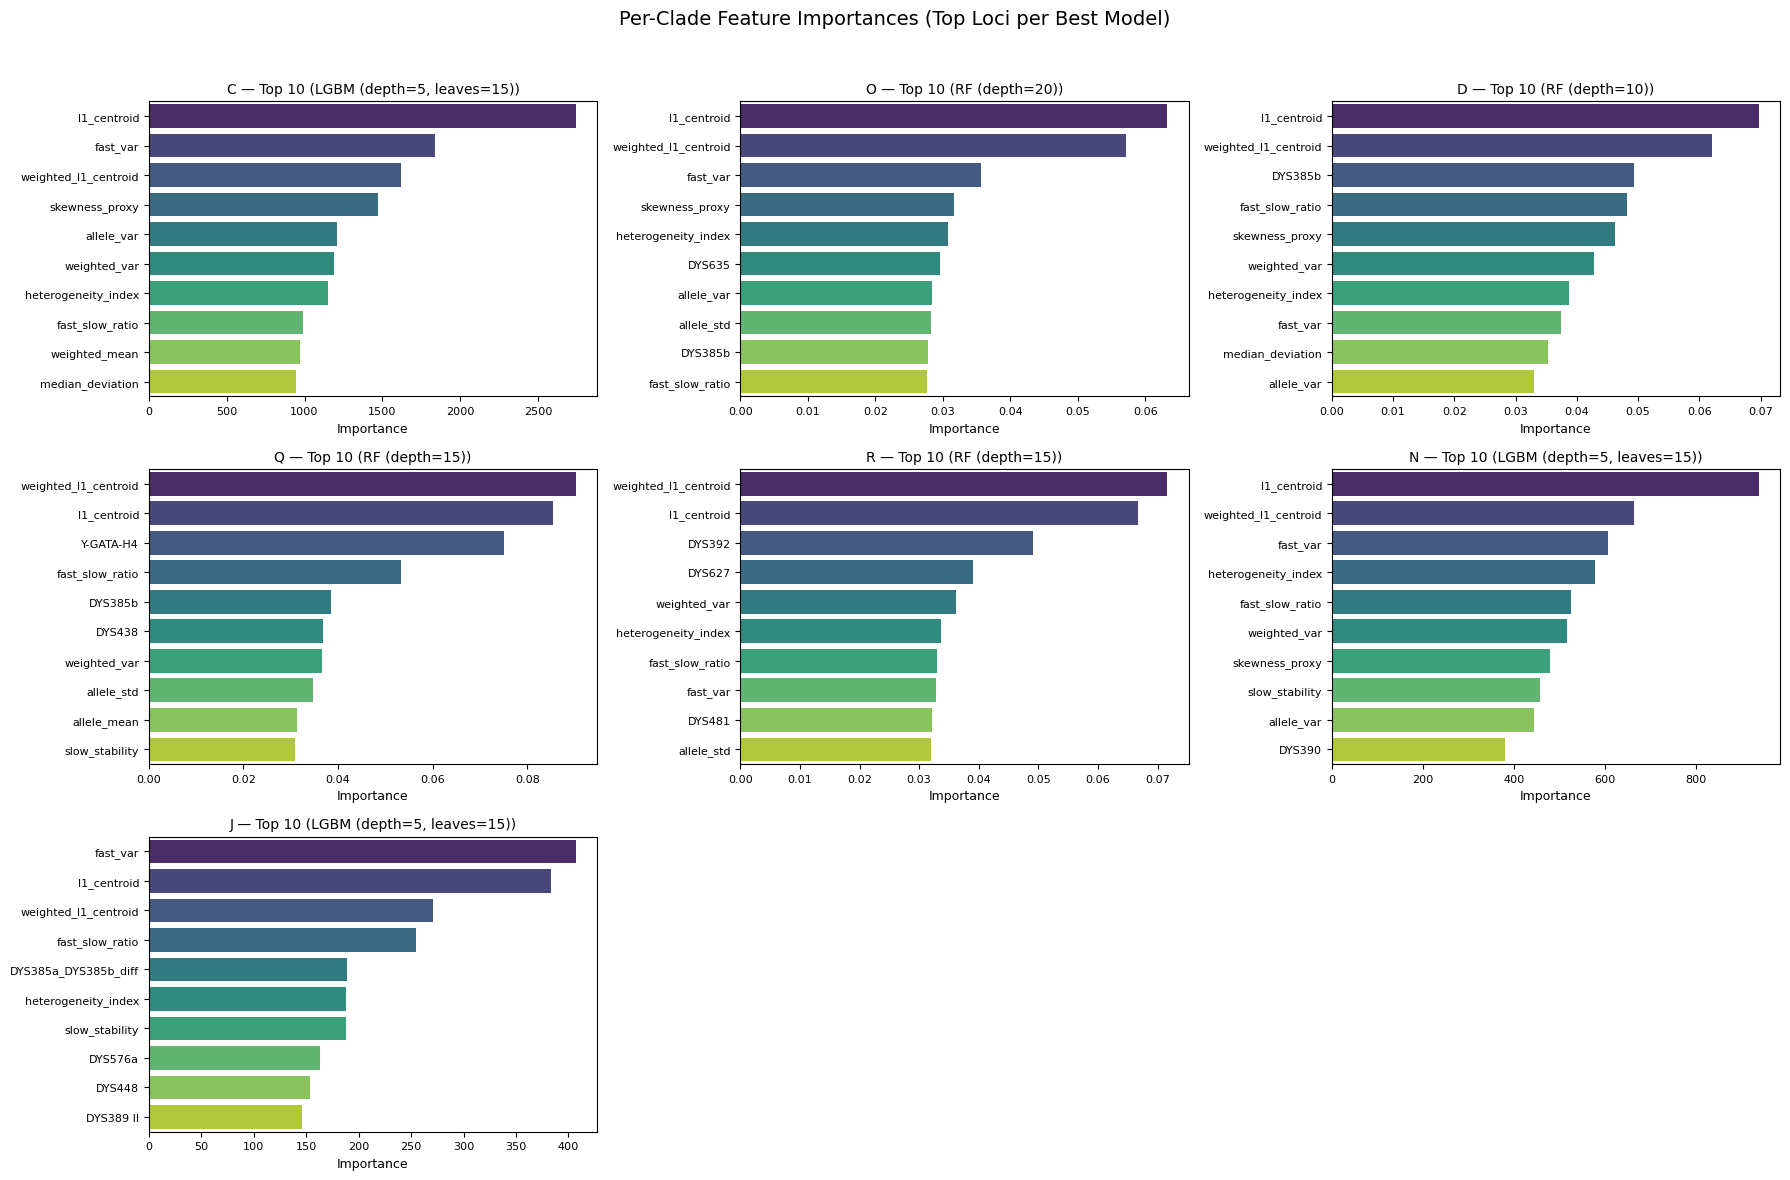

In [9]:
# ======================================================
# 7️⃣ IMPROVED PER-CLADE FEATURE IMPORTANCE VISUALIZATION (COMPACT CANVAS)
# ======================================================

def plot_feature_importances_canvas(sub_results_df, df, hap_col, n=10):
    """Plots top-n feature importances for each major clade in a single canvas."""

    # Prepare a list of clades to plot
    clades_to_plot = [
        c for c in sub_results_df["Clade"]
        if sub_results_df.loc[sub_results_df["Clade"] == c, "n_samples"].values[0] >= 20
    ]
    num_clades = len(clades_to_plot)

    if num_clades == 0:
        print("⚠️ No eligible clades to plot.")
        return

    # Determine subplot grid layout
    cols = 3
    rows = math.ceil(num_clades / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
    axes = axes.flatten()

    for ax_idx, clade in enumerate(clades_to_plot):
        ax = axes[ax_idx]

        row = sub_results_df[sub_results_df["Clade"] == clade].iloc[0]
        sub_df = df[df["major_clade"] == clade]
        sub_X = sub_df.iloc[:, 6:].apply(pd.to_numeric, errors='coerce')
        sub_y = sub_df[hap_col]

        # Skip small ones again just in case
        if sub_y.nunique() < 3 or len(sub_y) < 20:
            ax.axis("off")
            continue

        # Select the better model per clade
        use_rf = row["RF_F1_Test"] >= row["LGBM_F1_Test"]

        if use_rf:
            best_params = row["RF_Params"]
            model_name = f"RF (depth={best_params['max_depth']})"
            model = RandomForestClassifier(
                n_estimators=300,
                max_depth=best_params["max_depth"],
                min_samples_leaf=best_params["min_samples_leaf"],
                min_samples_split=10,
                max_features="sqrt",
                class_weight="balanced",
                n_jobs=-1,
                random_state=42
            )
        else:
            best_params = row["LGBM_Params"]
            model_name = (
                f"LGBM (depth={best_params['max_depth']}, "
                f"leaves={best_params['num_leaves']})"
            )
            model = LGBMClassifier(
                n_estimators=500,
                learning_rate=0.05,
                max_depth=best_params["max_depth"],
                num_leaves=best_params["num_leaves"],
                min_data_in_leaf=best_params["min_data_in_leaf"],
                reg_lambda=best_params["reg_lambda"],
                reg_alpha=best_params["reg_alpha"],
                feature_fraction=0.8,
                bagging_fraction=0.8,
                bagging_freq=5,
                is_unbalance=True,
                n_jobs=-1,
                random_state=42,
                verbose=-1
            )

        # Fit model and extract top features
        model.fit(sub_X, sub_y)

        if hasattr(model, "feature_importances_"):
            importances = pd.Series(model.feature_importances_, index=sub_X.columns)
            top_feats = importances.sort_values(ascending=False).head(n)
        else:
            ax.text(0.5, 0.5, "No importances", ha="center", va="center")
            ax.axis("off")
            continue

        # --- Fixed palette deprecation ---
        sns.barplot(
            x=top_feats.values,
            y=top_feats.index,
            hue=top_feats.index,        # <-- fixes palette warning
            legend=False,
            palette="viridis",
            ax=ax
        )

        ax.set_title(f"{clade} — Top {n} ({model_name})", fontsize=10)
        ax.set_xlabel("Importance", fontsize=9)
        ax.set_ylabel("")
        ax.tick_params(axis='x', labelsize=8)
        ax.tick_params(axis='y', labelsize=8)

    # Turn off any extra subplots
    for j in range(ax_idx + 1, len(axes)):
        axes[j].axis("off")

    fig.suptitle("Per-Clade Feature Importances (Top Loci per Best Model)", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# ======================================================
# 8️⃣ EXECUTE VISUALIZATION
# ======================================================
plot_feature_importances_canvas(sub_results_df, df, hap_col, n=10)

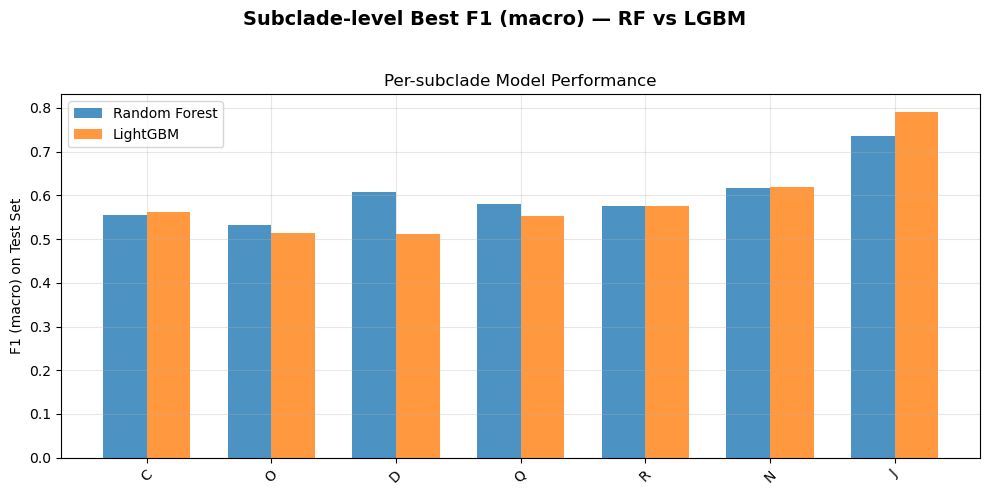

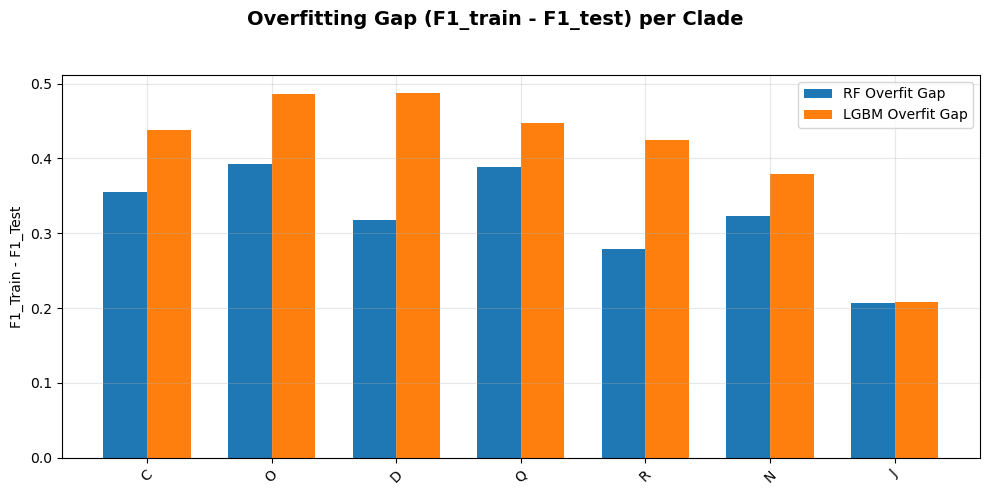

In [7]:
# ======================================================
# 🔍 VISUALIZE SUBCLADE PERFORMANCE & BEST PARAMS
# ======================================================

plt.figure(figsize=(10, 5))
plt.suptitle("Subclade-level Best F1 (macro) — RF vs LGBM", fontsize=14, weight="bold")

# --- Bar chart comparing best test F1 per clade ---
x = np.arange(len(sub_results_df))
bar_width = 0.35

plt.bar(x - bar_width/2, sub_results_df["RF_F1_Test"], width=bar_width, label="Random Forest", alpha=0.8)
plt.bar(x + bar_width/2, sub_results_df["LGBM_F1_Test"], width=bar_width, label="LightGBM", alpha=0.8)

plt.xticks(x, sub_results_df["Clade"], rotation=45)
plt.ylabel("F1 (macro) on Test Set")
plt.title("Per-subclade Model Performance")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# --- Overfitting gap plot ---
plt.figure(figsize=(10, 5))
plt.suptitle("Overfitting Gap (F1_train - F1_test) per Clade", fontsize=14, weight="bold")

plt.bar(x - bar_width/2, sub_results_df["RF_Overfit"], width=bar_width, label="RF Overfit Gap")
plt.bar(x + bar_width/2, sub_results_df["LGBM_Overfit"], width=bar_width, label="LGBM Overfit Gap")
plt.xticks(x, sub_results_df["Clade"], rotation=45)
plt.ylabel("F1_Train - F1_Test")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [8]:
# ======================================================
# 🔍 Sample Size vs Depth with F1 as Bubble Size
# ======================================================

plt.figure(figsize=(9, 6))
plt.suptitle("Subclade Sample Size vs Best Model Depth (Bubble = Test F1)", fontsize=14, weight="bold")

# Scale bubble sizes for visibility
rf_sizes = sub_results_df["RF_F1_Test"] * 800
lgbm_sizes = sub_results_df["LGBM_F1_Test"] * 800

# --- Random Forest ---
plt.scatter(sub_results_df["n_samples"], sub_results_df["RF_Depth"],
            s=rf_sizes, color="blue", alpha=0.6, label="Random Forest")

# --- LightGBM ---
plt.scatter(sub_results_df["n_samples"], sub_results_df["LGBM_Depth"],
            s=lgbm_sizes, color="orange", alpha=0.6, label="LightGBM")

# --- Annotate clades ---
for _, row in sub_results_df.iterrows():
    plt.text(row["n_samples"] + 10, row["RF_Depth"] + 0.15, row["Clade"], fontsize=9, color="gray")

plt.xlabel("Number of Samples per Subclade")
plt.ylabel("Best Depth (max_depth)")
plt.title("Relationship Between Subclade Size, Depth, and Performance")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

KeyError: 'RF_Depth'

<Figure size 900x600 with 0 Axes>

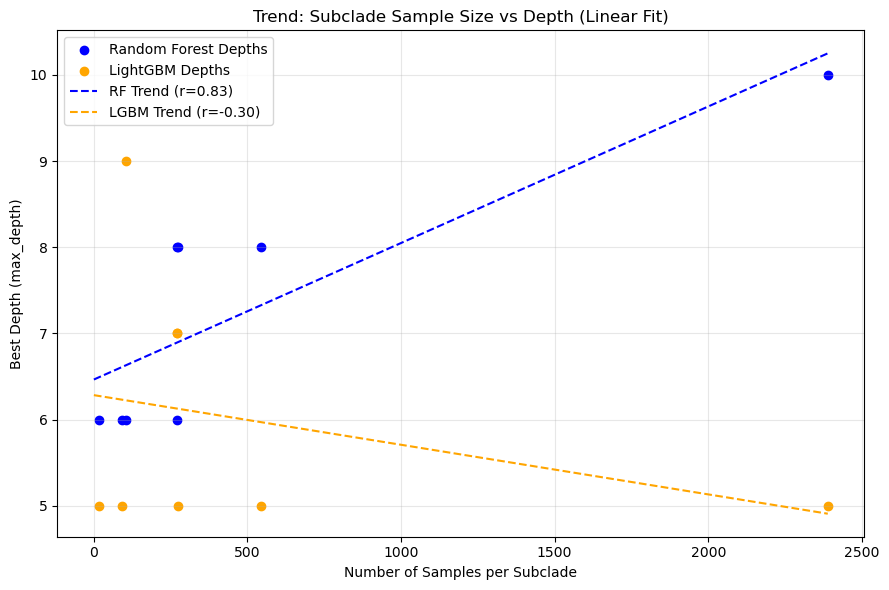

In [ ]:
# ======================================================
# 📈 TREND LINE + CORRELATION ANALYSIS
# ======================================================
from sklearn.linear_model import LinearRegression
import numpy as np

# Prepare data (drop NaNs)
rf_mask = sub_results_df["RF_Depth"].notna()
lgbm_mask = sub_results_df["LGBM_Depth"].notna()

X_rf = sub_results_df.loc[rf_mask, ["n_samples"]].values
y_rf = sub_results_df.loc[rf_mask, "RF_Depth"].values
X_lgbm = sub_results_df.loc[lgbm_mask, ["n_samples"]].values
y_lgbm = sub_results_df.loc[lgbm_mask, "LGBM_Depth"].values

# Fit simple linear models
rf_fit = LinearRegression().fit(X_rf, y_rf)
lgbm_fit = LinearRegression().fit(X_lgbm, y_lgbm)

# Plot trend lines
x_range = np.linspace(0, sub_results_df["n_samples"].max(), 100).reshape(-1, 1)
plt.figure(figsize=(9, 6))
plt.title("Trend: Subclade Sample Size vs Depth (Linear Fit)")
plt.scatter(X_rf, y_rf, color="blue", label="Random Forest Depths")
plt.scatter(X_lgbm, y_lgbm, color="orange", label="LightGBM Depths")
plt.plot(x_range, rf_fit.predict(x_range), "b--", label=f"RF Trend (r={np.corrcoef(X_rf[:,0], y_rf)[0,1]:.2f})")
plt.plot(x_range, lgbm_fit.predict(x_range), "orange", linestyle="--",
         label=f"LGBM Trend (r={np.corrcoef(X_lgbm[:,0], y_lgbm)[0,1]:.2f})")
plt.xlabel("Number of Samples per Subclade")
plt.ylabel("Best Depth (max_depth)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

,Depth,RF_F1_Train,RF_F1_Test,LGBM_F1_Train,LGBM_F1_Test,RF_Overfit,LGBM_Overfit
0,3.0,0.640150,0.533905,1.0,0.813230,0.106245,0.186770
1,5.0,0.910053,0.748468,1.0,0.748714,0.161585,0.251286
2,7.0,0.972726,0.797239,1.0,0.749379,0.175486,0.250621
3,9.0,0.979191,0.820203,1.0,0.749379,0.158987,0.250621
4,11.0,0.980674,0.821222,1.0,0.747820,0.159453,0.252180
5,13.0,0.981097,0.821885,1.0,0.749379,0.159212,0.250621
6,15.0,0.981312,0.822078,1.0,0.749379,0.159234,0.250621
7,NaN,0.981312,0.822696,1.0,0.749379,0.158616,0.250621


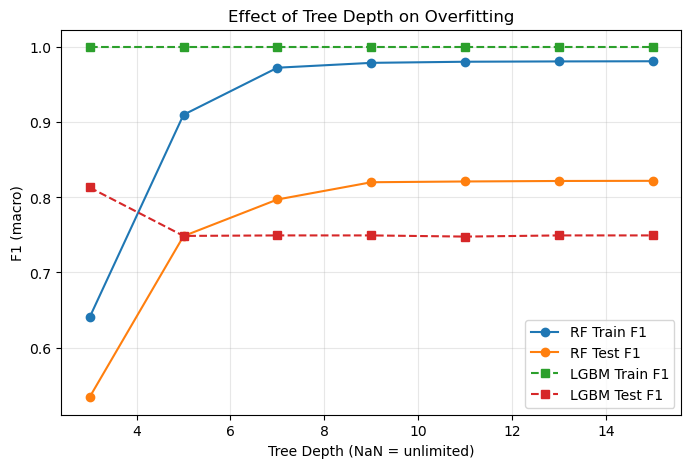

In [ ]:
# ======================================================
# 🔎 DEPTH SENSITIVITY ANALYSIS (Fixed for plotting)
# ======================================================

depth_range = [3, 5, 7, 9, 11, 13, 15, None]  # Try progressively deeper trees
results = []

for depth in depth_range:
    # --- Random Forest ---
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=depth,
        min_samples_leaf=5,
        min_samples_split=10,
        max_features="sqrt",
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    )
    rf.fit(X_train, y_train)
    y_pred_rf_train = rf.predict(X_train)
    y_pred_rf_test = rf.predict(X_test)
    rf_f1_train = f1_score(y_train, y_pred_rf_train, average="macro")
    rf_f1_test = f1_score(y_test, y_pred_rf_test, average="macro")

    # --- LightGBM ---
    lgbm = LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=31 if depth is None else min(2 ** depth // 2, 31),
        max_depth=-1 if depth is None else depth,
        min_data_in_leaf=10,
        feature_fraction=0.8,
        bagging_fraction=0.8,
        bagging_freq=5,
        reg_lambda=1.0,
        reg_alpha=0.5,
        is_unbalance=True,
        n_jobs=-1,
        random_state=42,
        verbose=-1
    )
    lgbm.fit(X_train, y_train)
    y_pred_lgbm_train = lgbm.predict(X_train)
    y_pred_lgbm_test = lgbm.predict(X_test)
    lgbm_f1_train = f1_score(y_train, y_pred_lgbm_train, average="macro")
    lgbm_f1_test = f1_score(y_test, y_pred_lgbm_test, average="macro")

    results.append({
        "Depth": depth if depth is not None else np.nan,  # ✅ use np.nan instead of string
        "RF_F1_Train": rf_f1_train,
        "RF_F1_Test": rf_f1_test,
        "LGBM_F1_Train": lgbm_f1_train,
        "LGBM_F1_Test": lgbm_f1_test,
        "RF_Overfit": rf_f1_train - rf_f1_test,
        "LGBM_Overfit": lgbm_f1_train - lgbm_f1_test
    })

# --- Summarize results ---
depth_df = pd.DataFrame(results)
display(depth_df)

# --- Clean and prepare for plotting ---
depth_df["Depth"] = depth_df["Depth"].astype(float)

# ======================================================
# 📈 Plot depth vs F1 for visual clarity
# ======================================================
plt.figure(figsize=(8, 5))
plt.plot(depth_df["Depth"], depth_df["RF_F1_Train"], 'o-', label="RF Train F1")
plt.plot(depth_df["Depth"], depth_df["RF_F1_Test"], 'o-', label="RF Test F1")
plt.plot(depth_df["Depth"], depth_df["LGBM_F1_Train"], 's--', label="LGBM Train F1")
plt.plot(depth_df["Depth"], depth_df["LGBM_F1_Test"], 's--', label="LGBM Test F1")

plt.xlabel("Tree Depth (NaN = unlimited)")
plt.ylabel("F1 (macro)")
plt.title("Effect of Tree Depth on Overfitting")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

visualize overfitting

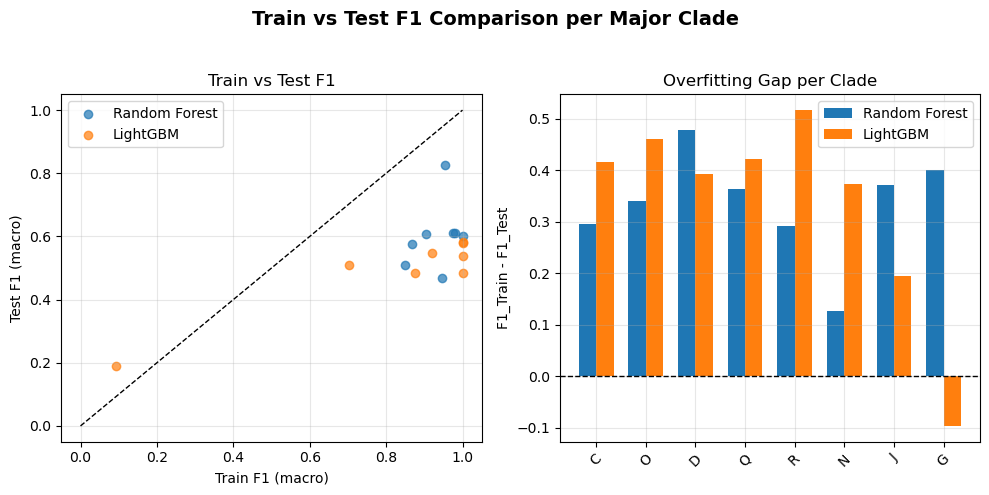

In [ ]:
# ======================================================
# 7️⃣ VISUALIZE OVERFITTING (Train vs Test F1)
# ======================================================

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))
plt.suptitle("Train vs Test F1 Comparison per Major Clade", fontsize=14, weight="bold")

# --- Scatter: Train vs Test ---
plt.subplot(1, 2, 1)
plt.scatter(sub_results_df["RF_F1_Train"], sub_results_df["RF_F1_Test"], label="Random Forest", alpha=0.7)
plt.scatter(sub_results_df["LGBM_F1_Train"], sub_results_df["LGBM_F1_Test"], label="LightGBM", alpha=0.7)
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("Train F1 (macro)")
plt.ylabel("Test F1 (macro)")
plt.title("Train vs Test F1")
plt.legend()
plt.grid(alpha=0.3)

# --- Bar: Overfitting Gap ---
plt.subplot(1, 2, 2)
bar_width = 0.35
x = np.arange(len(sub_results_df))
plt.bar(x - bar_width/2, sub_results_df["RF_Overfit"], width=bar_width, label="Random Forest")
plt.bar(x + bar_width/2, sub_results_df["LGBM_Overfit"], width=bar_width, label="LightGBM")
plt.axhline(0, color='k', linestyle='--', lw=1)
plt.xticks(x, sub_results_df["Clade"], rotation=45)
plt.ylabel("F1_Train - F1_Test")
plt.title("Overfitting Gap per Clade")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
cm = confusion_matrix(y_test, y_major_pred, labels=np.unique(y_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
plt.figure(figsize=(10,10))
disp.plot(cmap="Blues", xticks_rotation=90, values_format=".0f")
plt.title("Confusion Matrix — N1 Subclades")
plt.show()

NameError: name 'y_major_pred' is not defined

<b>Discussion</b>

Consider doing a confusion matrix?? For random forest, check where mistakes/confusions were made

Note:
- kNN is more suited for data with non-linear relationships
- Logistic Regression is more suited for binary classification problems, and assumes linearity between the dependent variable and independent variables
- SVM is more suited for datasets with no overlapping classes
- LDA is more suited for multi-class data classifications since it projects data into one dimension for easier classification (i.e. dimensionality reduction)
- Gaussian Naive Bayes is more suited for continuous data as it assumes the values follow a normal distribution
- Decision Tree and Random Forest are more suited for rule based problems, and handling discrete data
- GBM is prone to overfitting

# Recommendations

# References

[1] https://www.sciencedirect.com/science/article/abs/pii/S0379073824001944

[2] https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35/#:~:text=IN%20DEPTH%20ANALYSIS,scaling%20in%20the%20X%2DY%20plane.

[3] https://www.geeksforgeeks.org/machine-learning/Feature-Engineering-Scaling-Normalization-and-Standardization/

[4] https://www.geeksforgeeks.org/data-science/advantages-and-disadvantages-of-logistic-regression/

[5] https://medium.com/@haj122/when-and-when-not-to-use-svms-e9edea04d6ba

## Write-ups

# Mutation-Aware Feature Engineering for Y-STR Classification

## 1. Conceptual Overview

In Y-STR haplogroup classification, each individual is represented by allelic repeat counts across multiple loci (e.g., DYS390, DYS391). However, these raw allele counts alone lack biological context — not all loci mutate at the same rate, and not all variation carries the same information about ancestry.

The following engineered features are designed to:

- Encode mutation rate heterogeneity among loci  
- Capture intra-haplogroup cohesion and distance to population-level centroids  
- Quantify global allele distributional statistics (mean, variance, skewness)  
- Normalize across loci for robust input to machine learning models such as Random Forests or Gradient Boosting

---

## 2. Haplogroup Centroid Features

### `l1_centroid`

For each sample $i$ belonging to haplogroup $h$, we compute:

$$
d_{L1}(i,h) = \sum_{j \in L} |x_{ij} - \mu_{hj}|
$$

where $\mu_{hj}$ is the mean allele count of haplogroup $h$ at locus $j$.

This feature measures how typical or atypical a Y-STR profile is relative to its haplogroup centroid — a measure of intra-clade genetic distance using the L1 norm (Manhattan distance).

- Low values indicate samples tightly clustered within the haplogroup  
- High values may indicate rare or boundary haplotypes

---

### `weighted_l1_centroid`

A variant of the above where loci are weighted according to mutation rates:

$$
d_{L1,w}(i,h) = \sum_{j \in L} w_j |x_{ij} - \mu_{hj}|
$$

Weights reflect mutation dynamics:

- Fast loci (e.g., DYS570, DYS576) mutate quickly and contribute less phylogenetic stability  
- Slow loci (e.g., DYS437, DYS389I/II) are evolutionarily conservative and have higher discriminative power

This feature incorporates region-specific mutation rates (East Asian context) to encode evolutionary priors into the model.

---

## 3. Global Allelic Distribution Features

| Feature | Definition | Interpretation |
|----------|-------------|----------------|
| `allele_sum` | $\sum_j x_{ij}$ | Proxy for total allelic load (total repeat count) |
| `allele_mean` | $\frac{1}{L} \sum_j x_{ij}$ | Average repeat count across loci |
| `allele_var` | $\text{Var}(x_{ij})$ | Dispersion of allele counts, reflecting within-sample heterogeneity |
| `allele_std` | $\sqrt{\text{Var}(x_{ij})}$ | Standard deviation, used for normalization and skew calculations |
| `allele_median` | $\text{Median}(x_{ij})$ | Robust measure of central tendency |

These features describe the overall distribution of allelic values within each STR profile.

---

## 4. Distributional Shape Descriptors

### `median_deviation`

$$
\text{median\_deviation} = \text{median} - \text{mean}
$$

Measures central tendency bias — positive values indicate right-skew (heavier upper tail), negative indicate left-skew.

### `skewness_proxy`

$$
\text{skewness\_proxy} = \frac{\text{mean} - \text{median}}{\text{std} + 10^{-9}}
$$

An approximation of Pearson’s second skewness coefficient, normalized by standard deviation.  
Detects asymmetric allele distributions that may correlate with unusual mutation histories.

---

## 5. Mutation-Category-Specific Variation

### `fast_var`

Variance computed only across fast-mutating loci.  
High values indicate strong intra-haplogroup microvariation.

### `slow_stability`

$$
\text{slow\_stability} = - \sum_{j \in L_{\text{slow}}} |x_{ij} - \mu_j|
$$

Quantifies stability for slow loci.  
Since deviations are negated, less negative values imply higher stability, serving as a proxy for phylogenetic conservatism.

---

## 6. Inter-Category Ratios and Dispersion Indices

### `fast_slow_ratio`

$$
R_{FS} = \frac{\overline{x}_{\text{fast}}}{\overline{x}_{\text{slow}} + \epsilon}
$$

Captures the relative expansion of fast vs. slow loci.  
High ratios suggest recent diversification or mutation accumulation.

### `heterogeneity_index`

$$
H = \frac{\text{allele\_std}}{\text{allele\_mean} + \epsilon}
$$

A normalized measure of intra-profile variability, analogous to a coefficient of variation.

---

## 7. Locus-Pair Differential Features

Certain loci (e.g., DYS385a/b, DYS389I/II) occur as duplicated regions on the Y chromosome and evolve in tandem.

| Feature | Definition | Interpretation |
|----------|-------------|----------------|
| `DYS385a_DYS385b_diff` | $DYS385a - DYS385b$ | Intra-pair divergence, useful for distinguishing subclades |
| `DYS389I_DYS389II_diff` | $DYS389I - DYS389II$ | Divergence between the two DYS389 loci, informative for deeper branching |

These localized features highlight pairwise mutational asymmetry, useful for differentiating closely related haplotypes.

---

## 8. Weighted Summary Statistics

### `weighted_mean` and `weighted_var`

Each locus is weighted by its mutation rate $w_j$:

$$
\text{weighted\_mean} = \frac{1}{L}\sum_j w_j x_{ij}
$$

$$
\text{weighted\_var} = \frac{1}{L}\sum_j w_j (x_{ij} - \text{weighted\_mean})^2
$$

These capture mutation-rate-aware global properties of each STR profile, emphasizing stable markers while accounting for variability at faster loci.

---

## 9. Normalization for Machine Learning

All continuous features are standardized using:

$$
z = \frac{x - \mu}{\sigma}
$$

via `StandardScaler`. This ensures comparability among features with different biological scales (e.g., raw counts vs. distances), improving model stability and performance.

---

## 10. Summary of Engineered Features

| Category | Features | Purpose |
|-----------|-----------|---------|
| Centroid distance | `l1_centroid`, `weighted_l1_centroid` | Within-haplogroup compactness; evolutionary weighting |
| Global stats | `allele_sum`, `allele_mean`, `allele_var`, `allele_std`, `allele_median` | Describe overall allele distribution |
| Shape metrics | `median_deviation`, `skewness_proxy` | Capture asymmetry and mutation bias |
| Mutation-specific | `fast_var`, `slow_stability`, `fast_slow_ratio` | Encode mutation-rate heterogeneity |
| Dispersion ratio | `heterogeneity_index` | Normalized variability across loci |
| Locus differentials | `DYS385a_DYS385b_diff`, `DYS389I_DYS389II_diff` | Localized mutational divergence |
| Weighted summaries | `weighted_mean`, `weighted_var` | Mutation-rate-adjusted global descriptors |
| Scaled features | All above normalized | Model robustness and comparability |

---

## 11. Why These Features Matter

This feature set integrates population genetics theory with statistical feature design:

- Reduces within-class variance while preserving between-class separability  
- Incorporates biologically meaningful mutation-rate priors  
- Provides robustness to missing or noisy STRs via aggregation  
- Produces interpretable predictors (e.g., centroid distance as biological typicality)

Overall, this design bridges population genetics and machine learning, yielding a biologically interpretable feature space for Y-STR haplogroup classification.


# Model Evaluation Metrics for Y-STR Haplogroup Classification

## 1. Overview

To evaluate the performance of classifiers trained on Y-STR data (e.g., Random Forest, LightGBM), we employ a suite of **multi-class performance metrics** designed to capture accuracy, balance, and generalization across unevenly distributed haplogroups.

The dataset exhibits **hierarchical class structure** (major clades → subclades) and **class imbalance** (some haplogroups have far fewer samples).  
Therefore, standard accuracy alone is insufficient — metrics like **macro-averaged F1**, **balanced accuracy**, and **Matthews Correlation Coefficient (MCC)** provide a more robust evaluation.

---

## 2. Accuracy

**Definition:**

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

In a multi-class context:

$$
\text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total number of samples}}
$$

Accuracy provides an overall measure of correctness, but it can be **misleading under class imbalance** — high accuracy can occur even if minority haplogroups are misclassified entirely.

**Interpretation:**
- High accuracy means most samples are correctly classified across all classes.
- However, accuracy does not account for per-class representation.

---

## 3. Precision, Recall, and F1-Score

These metrics are computed **per class** and then averaged. They are fundamental to understanding trade-offs between **false positives** and **false negatives**.

### Precision

$$
\text{Precision}_k = \frac{TP_k}{TP_k + FP_k}
$$

Measures how many predicted members of class $k$ are actually correct.

- High precision → few false positives  
- In Y-STR terms: when the model predicts haplogroup *R1a*, it’s often correct.

### Recall (Sensitivity)

$$
\text{Recall}_k = \frac{TP_k}{TP_k + FN_k}
$$

Measures how many true members of class $k$ were successfully identified.

- High recall → few false negatives  
- In Y-STR terms: most true *R1a* individuals are captured by the model.

### F1-Score

The **harmonic mean** of precision and recall:

$$
F1_k = 2 \cdot \frac{\text{Precision}_k \cdot \text{Recall}_k}{\text{Precision}_k + \text{Recall}_k}
$$

The harmonic mean penalizes extreme imbalance (e.g., perfect precision but poor recall).

---

## 4. Macro-Averaged F1 (Used in This Project)

To obtain a single number summarizing performance across all haplogroups:

$$
F1_{\text{macro}} = \frac{1}{K} \sum_{k=1}^K F1_k
$$

- **Each class contributes equally**, regardless of frequency.  
- This is crucial for **imbalanced datasets**, ensuring that rare haplogroups (e.g., *G*, *L*) are weighted equally to dominant ones (e.g., *O*, *R*).

**Interpretation:**
- A high macro-F1 implies balanced performance across both common and rare haplogroups.
- A large gap between training and test macro-F1 indicates **overfitting** (model memorizing rare haplogroups).

---

## 5. Balanced Accuracy

Balanced accuracy adjusts for class imbalance by averaging recall over all classes:

$$
\text{Balanced Accuracy} = \frac{1}{K} \sum_{k=1}^{K} \frac{TP_k}{TP_k + FN_k}
$$

Equivalent to **macro-averaged recall**.  
This metric ensures that each haplogroup contributes equally to the score, even if its sample size is small.

**Interpretation:**
- High balanced accuracy indicates the model performs fairly across classes.
- Useful in biological datasets where some lineages are underrepresented.

---

## 6. Matthews Correlation Coefficient (MCC)

MCC provides a **single correlation measure** between observed and predicted classifications:

$$
MCC = \frac{TP \times TN - FP \times FN}
{\sqrt{(TP + FP)(TP + FN)(TN + FP)(TN + FN)}}
$$

For multi-class problems, MCC generalizes to:

$$
MCC = \frac{c \times s - \sum_k p_k t_k}
{\sqrt{(c^2 - \sum_k p_k^2)(c^2 - \sum_k t_k^2)}}
$$

where:
- $c$ = total samples  
- $t_k$ = true count for class $k$  
- $p_k$ = predicted count for class $k$  
- $s$ = total number of correct predictions

**Interpretation:**
- $MCC = 1$ → perfect prediction  
- $MCC = 0$ → random guessing  
- $MCC < 0$ → inverse or systematically wrong predictions  

MCC is robust to class imbalance and is widely used in **genomic classification tasks**.

---

## 7. Confusion Matrix

The **confusion matrix** visualizes how predictions distribute across classes.

For $K$ classes, it is a $K \times K$ matrix $C$, where:

$$
C_{ij} = \text{number of samples with true class } i \text{ predicted as } j
$$

- Diagonal entries ($C_{ii}$): correctly predicted samples  
- Off-diagonal entries: misclassifications

**Interpretation:**
- Blocks of confusion between related haplogroups (e.g., *O1a* vs *O1b*) often reflect biological proximity.
- The matrix provides a valuable tool for understanding systematic misclassification patterns.

---

## 8. Overfitting Analysis (Train vs Test)

To assess overfitting, compare train vs test macro-F1:

$$
\Delta F1 = F1_{\text{train}} - F1_{\text{test}}
$$

- Small $\Delta F1$ → model generalizes well  
- Large $\Delta F1$ → potential overfitting (especially in rare classes)

In your experiment, this difference is reported as:

- `RF_Overfit` = RF train F1 - test F1  
- `LGBM_Overfit` = LGBM train F1 - test F1

---

## 9. Summary Table

| Metric | Purpose | Robust to Imbalance | Interpretation |
|:--------|:---------|:--------------------|:----------------|
| Accuracy | Overall correctness | No | Sensitive to dominant classes |
| Precision | Confidence in positive predictions | Yes (per class) | Penalizes false positives |
| Recall | Completeness of detection | Yes (per class) | Penalizes false negatives |
| F1-score | Balance of precision & recall | Yes | Unified detection performance |
| Macro-F1 | Equal weighting of all classes | Yes | Key for imbalanced haplogroups |
| Balanced Accuracy | Equalized recall across classes | Yes | Stability across uneven distributions |
| MCC | Correlation between true & predicted | Yes | Most informative single metric |
| Confusion Matrix | Diagnostic visualization | — | Shows specific misclassifications |

---

## 10. Practical Summary

- **Macro-F1** and **MCC** are your most informative metrics for biological interpretability.  
- **Accuracy** alone is insufficient in the presence of rare haplogroups.  
- **Confusion matrices** reveal where the classifier struggles — often within phylogenetically close subclades.  
- **Train–test F1 gaps** quantify generalization capacity and reveal overfitting tendencies.

This combination of metrics provides a comprehensive, statistically balanced view of model performance on hierarchical, imbalanced, and biologically meaningful Y-STR datasets.
